# 1. Introduction


## 1.1 Research Background


This report is for mining high-utility itemset.

High-utility itemset which is mining has begun as a very important extension of transaction frequent item mining can be appear multi times in transaction.

The incorporation of high utility transforms the mining task from a frequency based approach to one which is considers the ecomical and strangtic importace of itemsets.
However, two import factors complicate this process of mining:

1. Data Uncertainty: Transaction database often contains uncertain data use for:

  - Data collection error or its noise
  - Probabilistic nature of data which gather process
  - Privacy-preserving the data transformation
  - Incomplete and estimated information


2. Positive and negative profit: Items can have both positive and negative utilities:

  - Positive utilities: profits, benefits, gains
  - Negative utilities: losses, costs, risks

3. Top-K Pattern Finding:
Instead of use a minimum utility threshold, finding the K most valuable patterns is often more appliable for decision makers.

## 1.2 Problem Statement


1. **Discovering High-Utility Itemsets**:
   - Identifing the itemsets that have the highest expect utility values in the database.
   - The utility of an itemset represent its important, interestingness, or profitability.

2. **Consider Transaction Probabilities**:
   - Incorporating the exist probability of each transaction into the utility computations.
   - In uncertain databases, each transaction has a probability indicating the likelihood of its occurrence.
   - The expected utility of an itemset should be computed based on these probabilities.

3. **Handle Positive and Negative Utilities**:
   - Allow items to have both positive and negative utility values within transactions.
   - Positive utility indicates profit or benefit, while negative utility represents cost or loss.
   - The algorithm should be able to handle the presence of both positive and negative utilities in the database.

4. **Return Top-K Itemsets**:
   - The objective is to find exactly K itemsets with the highest expected utility values.
   - The value of K is a user-specified parameter that determines the number of desired high-utility itemsets.
   - The algorithm should return neither more nor less than K itemsets.


By addressing these objectives, this research aims to provide a comprehensive solution for mining the Top-K High-Utility Itemsets from uncertain databases, considering both positive and negative item utilities and transaction probabilities. The discovered itemsets will represent the most valuable and interesting patterns in the uncertain data, enabling better decision-making and knowledge discovery.

# 2. Problem Definition

## 2.1 Basic Concepts and Terminology

### 2.1.1 Itemset and Transaction

1. Item: Represents an individual item in a transaction, with the following attributes:

  - name: The name/identifier of the item
  - quantity: The quantity of the item in the transaction


2. Transaction: Represents a single transaction, with the following attributes:

  - tid: The unique identifier of the transaction
  - items: A list of Item objects contained in the transaction
  - probability: The probability or likelihood of the transaction occurring


3. ProfitTable: A dictionary that maps item names to their respective profit/utility values.
4. TopKEntry: Represents an entry in the final top-K high utility itemsets, with the following attributes:

  - itemset: The list of items in the itemset
  - utility: The total utility/expected utility of the itemset
  - probability: The probability of the itemset occurring

## 2.2 Input Data Structures

In [15]:
from typing import Dict, List, Optional, Union, Tuple, Any

### 2.2.1 Item Class

In [16]:
from typing import List, Dict, Optional, Union

class Item:
    """
    This class is use to present an item in an transaction with its name and
    coresponding quantity

    An Item has 2 basic information, and it is a basic unit in the transaction
    in the database that use to store:
    - The item's identifier id which is unique
    - the coressponding quantity of this item in the correctponding transaction

    This class is a fundamental method use for presenting items within transaction
    that can calcualte utility.

    Attributes:
        name (str): Unique identifier of the item
        quantity (int): Number of units of this item

    Example:
        >>> item = Item("A", 3)
        >>> print(item)
        Item(name='A', quantity=3)
    """

    def __init__(self, name: str, quantity: int) -> None:
        """
        Initialize a new item instance

        Args:
            name: The unique identifier/name of the item
            quantity: The quantity of the item (must be non-negative)
        """
        self.name: str = name       # Unique identifier for the item
        self.quantity: int = quantity   # Number of units of this item

    def __repr__(self) -> str:
        """
        Return a String that represent of an item.

        Format: Item(name='item_name', quantity=item_quantity)

        Returns:
            Format string representation of the Item instance
        """
        return f"Item(name='{self.name}', quantity={self.quantity})"



### 2.2.2 Transaction Class

In [57]:

class Transaction:
    """
    This class use to represent an uncertain transaction that include items and its
    probabilities

    A Transaction that is in an uncertain dataset, including:
    - A unique id of transaction (identifier id)
    - A list of Items and their quantities
    - A probability value that represent of the transaction

    This class is crucial for handling uncertain database in algorithm
    as it maintain for both the transaction and its coresponding probability

    Attributes:
        tid (int): Unique identifier of transaction
        items (List[Item]): List of items
        probability (float): Probability that belong to an transaction (0 to 1)

    Example:
        >>> items = [Item("A", 2), Item("B", 1)]
        >>> trans = Transaction(1, items, 0.8)
        >>> print(trans)
        Transaction(tid=1, items=[Item(name='A', quantity=2), Item(name='B', quantity=1)], probability=0.8)
    """

    def __init__(self, tid: int, items: List[Item], probability: float) -> None:
        """
        Create a new Transaction instance

        Args:
            tid: Unique identifier for transaction (unique)
            items: List of Items in the transaction
            probability: Probability value between 0 and 1

        Raises:
            ValueError: If probability is not between 0 and 1
        """
        if not 0 <= probability <= 1:
            raise ValueError("Probability must be between 0 and 1")

        self.tid: int = tid            # Unique transaction identifier
        self.items: List[Item] = items  # List of Items in transaction
        self.probability: float = probability  # Transaction probability

    def __repr__(self) -> str:
        """
        Return a string representation of the Transaction.

        Format: Transaction(tid=transaction_id, items=[item_list], probability=prob_value)

        Returns:
            Formatted string representation of the Transaction instance
        """
        return f"Transaction(tid={self.tid}, items={self.items}, probability={self.probability})"


### 2.2.3 Profit Table Class

In [58]:

class ProfitTable:
    """
    This class is used for mantaining a map of items to its unit profit values

    The ProfitTable serve as a looking up table for utility of items (profit also)
    and is crucial for both computing transaction utilities and itemset utilities.

    Key Features:
    - Dynamic profit value that can be updated
    - Dictionary-based storage for O(1) lookups

    Attributes:
        profit_dict (Dict[str, float]): Dictionary mapping item names to their profit values

    Example:
        >>> pt = ProfitTable()
        >>> pt.add_profit("A", 10)
        >>> pt.add_profit("B", -5)
        >>> print(pt.get_profit("A"))
        10
        >>> print(pt)
        {'A': 10, 'B': -5}
    """

    def __init__(self) -> None:
        """
        Intial an empty profit table

        This class' attribute stores item and its coresspoding profit mappings
        where profits can be both positive and negative

        """
        self.profit_dict: Dict[str, float] = {}  # Dictionary mapping items to their profit values

    def add_profit(self, item_name: str, profit: Union[int, float]) -> None:
        """
        Add and update the profit value of this item

        Args:
            item_name: The name/identifier of the item
            profit: The unit profit value (can be positive or negative)

        Example:
            >>> pt = ProfitTable()
            >>> pt.add_profit("A", 10.5)
            >>> pt.add_profit("B", -5)

        """
        self.profit_dict[item_name] = float(profit)

    def get_profit(self, item_name: str) -> float:
        """
        This use for retriving the profit value for item in itemset

        Args:
            item_name: The name/identifier of the item

        Returns:
            The profit value for the item, or 0 if item not found

        Example:
            >>> pt = ProfitTable()
            >>> pt.add_profit("A", 10)
            >>> print(pt.get_profit("A"))
            10.0
            >>> print(pt.get_profit("B"))  # Unknown item
            0.0
        """
        return self.profit_dict.get(item_name, 0.0)

    def __repr__(self) -> str:
        """
        Returen a string of representing of the ProfitTable

        Format: Dictionary representation of item-profit mappings

        Returns:
            String representation of the profit dictionary

        """
        return str(self.profit_dict)

### 2.2.4 Support Data Structures

In [19]:
class TrieNode:
    """

    This class is a node for the Trie Tree dataset structure that ised in mining

    A TrieNode represents a node in the Trie Tree and stores it into storage structure:
    - It referece to child nodes (children)
    - Flag that indicate if it represents end of an itemset (is_end)
    - Utility for the itemset which is ending at this node (utility)

    The node structure allow effcient prefix - based storahe and can retrieval
    of itemsets and its utilities.

    Attributes:
        children (Dict[str, 'TrieNode']): Dictionary map items to child nodes
        is_end (bool): Flag indicate if node represents end of an itemset
        utility (float): Utility value for itemset ending at this node

    Example:
        >>> node = TrieNode()
        >>> node.children['A'] = TrieNode()
        >>> print(node)
        TrieNode(children=['A'], is_end=False, utility=0)
    """

    def __init__(self) -> None:
        """
        Create a new Node of Trie

        Creates an empty node with:
        - No children (empty dictionary)
        - Not consider as end of itemset (mark)
        - Zero utility value
        """
        self.children: Dict[str, 'TrieNode'] = {}  # Child nodes, keyed by item name
        self.is_end: bool = False                  # Flag for end of itemset
        self.utility: float = 0                    # Utility value if node ends an itemset

    def __repr__(self) -> str:
        """
        Returns a string  of the TrieNode.

        Format: TrieNode(children=[list_of_child_keys], is_end=bool_value, utility=utility_value)

        Returns:
            str: Formatted string representation of node state
        """
        return f"TrieNode(children={list(self.children.keys())}, is_end={self.is_end}, utility={self.utility})"


class TrieTree:
    """
    This class is as Trie Tree data structure for store and access itemset more efficency

    The TrieTree structure that provided a space way to stroe itemsets and its utilites
    by share common prefixes, and it supports:
    - Insert of itemsets with its utility
    - Can search for itemsets and retrieve of its utilites
    - Operate prefix-based

    Key Features:
    - O(m) insert and search time, where m is itemset length
    - Space-efficient strore of itemsets with common prefix
    - Utility value storage at terminal nodes

    Attributes:
        root (TrieNode): Root node of the trie tree

    Example:
        >>> tree = TrieTree()
        >>> tree.insert(('A', 'B'), 100)
        >>> print(tree.search(('A', 'B')))
        100
        >>> print(tree.search(('A', 'C')))
        None
    """

    def __init__(self) -> None:
        """
        Initialize a new TrieTree with an empty root node.
        """
        self.root: TrieNode = TrieNode()

    def insert(self, itemset: Tuple[str, ...], utility: float) -> None:
        """
        Add an itemset then its utility value to the trie

        traveeral the trie following to the itemset sequence, creating new nodes
        if needed, then stores the coressponfing value at the termial node.

        Time Complexity: O(m) where m is length of itemset

        Args:
            itemset: Tuple of item names representing the itemset
            utility: Utility value associated with the itemset

        Example:
            >>> tree = TrieTree()
            >>> tree.insert(('A', 'B'), 100)
            >>> tree.insert(('A', 'C'), 50)
        """
        node: TrieNode = self.root

        # Traverse/create path for itemset
        for item in itemset:
            if item not in node.children:
                node.children[item] = TrieNode()
            node = node.children[item]

        # Mark end and store utility
        node.is_end = True
        node.utility = utility

    def search(self, itemset: Tuple[str, ...]) -> Optional[float]:
        """
        Search for an itemset and return its utility value if found.

        Traverses the trie following the itemset sequence and returns the
        utility value if the itemset exists and ends at a terminal node.

        Time Complexity: O(m) where m is length of itemset

        Args:
            itemset: Tuple of item names to search for

        Returns:
            Utility value if itemset found and ends at terminal node, None otherwise

        Example:
            >>> tree = TrieTree()
            >>> tree.insert(('A', 'B'), 100)
            >>> print(tree.search(('A', 'B')))
            100.0
            >>> print(tree.search(('A')))  # Non-terminal node
            None
            >>> print(tree.search(('C')))  # Non-existent path
            None
        """
        node: TrieNode = self.root

        # Traverse path for itemset
        for item in itemset:
            if item not in node.children:
                return None  # Path doesn't exist
            node = node.children[item]

        # Return utility if path exists and ends at terminal node
        return node.utility if node.is_end else None

    def __repr__(self) -> str:
        """
        Returns a string representation of the TrieTree.

        Returns:
            str: Simple string indicating TrieTree object
        """
        return "TrieTree()"


class PUEntry:
    """
    Represents an entry in the PU±-List structure that stores transaction ID,
    probability and utility information for an item/itemset.

    PU±-List is used to efficiently store and compute utility information
    for items and itemsets while considering transaction probabilities.

    Attributes:
        tid (int): Transaction ID this entry corresponds to
        probability (float): Probability of the transaction [0,1]
        utility (float): Utility value (can be positive or negative)

    Example:
        >>> entry = PUEntry(tid=1, probability=0.8, utility=10.5)
        >>> print(entry)
        PUEntry(tid=1, probability=0.8, utility=10.5)
    """

    def __init__(self, tid: int, probability: float, utility: float):
        """
        Initialize a PUEntry instance.

        Args:
            tid: Transaction identifier
            probability: Transaction probability between 0 and 1
            utility: Utility value (positive or negative)

        Raises:
            ValueError: If probability not in [0,1]
        """
        if not 0 <= probability <= 1:
            raise ValueError("Probability must be between 0 and 1")

        self.tid = tid
        self.probability = probability
        self.utility = utility

    def __repr__(self) -> str:
        """String representation for debugging."""
        return f"PUEntry(tid={self.tid}, probability={self.probability}, utility={self.utility})"

    def __eq__(self, other) -> bool:
        """Equality comparison."""
        if not isinstance(other, PUEntry):
            return False
        return (self.tid == other.tid and
                self.probability == other.probability and
                self.utility == other.utility)

    def __hash__(self) -> int:
        """Hash function for using PUEntry in sets/dicts."""
        return hash((self.tid, self.probability, self.utility))

    @property
    def expected_utility(self) -> float:
        """Calculate expected utility considering probability."""
        return self.utility * self.probability


## 2.3 Output Data Structure
### 2.3.1 Top-K Entry Class

In [20]:
from typing import List

class TopKEntry:
    """
    Represents an entry in the top-k high utility itemsets results.

    A TopKEntry stores a high utility itemset along with its utility value
    and occurrence probability in an uncertain database.

    Attributes:
        itemset (List[str]): List of items forming the pattern
        utility (float): Expected utility value of the itemset
        probability (float): Occurrence probability in uncertain database

    Example:
        >>> entry = TopKEntry(['A', 'B'], 100.0, 0.8)
        >>> print(entry)
        TopKEntry(itemset=[A, B], utility=100.0, probability=0.8)
    """

    def __init__(self, itemset: List[str], utility: float, probability: float) -> None:
        """
        Initialize a new TopKEntry instance.

        Args:
            itemset: List of item identifiers in the pattern
            utility: Expected utility value
            probability: Occurrence probability (0 to 1)

        Raises:
            ValueError: If probability not in [0,1] or utility is negative
        """
        if not 0 <= probability <= 1:
            raise ValueError("Probability must be between 0 and 1")
        #if utility < 0:
        #    raise ValueError("Utility cannot be negative")

        self.itemset: List[str] = itemset        # List of items in the pattern
        self.utility: float = float(utility)      # Expected utility value
        self.probability: float = float(probability)  # Pattern occurrence probability

    def __repr__(self) -> str:
        """
        Returns a string representation of the TopKEntry.

        Returns:
            str: Formatted string showing itemset, utility, and probability
        """
        itemset_str: str = ', '.join(self.itemset)
        return f"TopKEntry(itemset=[{itemset_str}], utility={self.utility}, probability={self.probability})"

## 2.5 Example

**Input:**

In [21]:
# Transactions
transactions = [
    Transaction(1, [Item("A", 2), Item("B", 1)], 0.8),
    Transaction(2, [Item("A", 1), Item("C", 3)], 0.6),
    Transaction(3, [Item("B", 2), Item("C", 1)], 0.9)
]

# Profit Table
profit_table = ProfitTable()
profit_table.add_profit("A", 5)   # Profit of $5
profit_table.add_profit("B", -2)  # Loss of $2
profit_table.add_profit("C", 9)   # Profit of $9

# Parameters
K = 2
min_prob = 0.5

**Output:**

In [22]:
[
    TopKEntry(["A"], 8.0, 0.7),      # High utility, probable pattern
    TopKEntry(["C"], 5.4, 0.75)      # Next best pattern
]

[TopKEntry(itemset=[A], utility=8.0, probability=0.7),
 TopKEntry(itemset=[C], utility=5.4, probability=0.75)]

# 3. Algorithm Implementations

## 3.1 Overview of Approaches

We implement and analyze five algorithms for mining Top-K high-utility itemsets from uncertain databases:

## HUPT (Algorithm 1)

1. TWU Calculation (calculate_TWU)

- Upper bound estimate for pruning
- Reduces initial search space
- Linear time complexity


2. HUP-List Structure (build_hup_list)

- Stores exact and remaining utility
- Enables efficient pruning
- Supports probability integration


3. Main Mining Procedure (HUPT_miner)

- Pattern growth approach
- Dynamic threshold adjustment
- Multiple pruning strategies





In [23]:
"""
High Utility Pattern Mining with Transaction Probability (HUPT) Algorithm

This module provides an optimized implementation of the HUPT algorithm for discovering high-utility patterns
from uncertain databases. By using direct data storage structures instead of relying on caches, the algorithm
delivers better performance and improved memory efficiency.

Key Features:
- Direct storage of transactions, bypassing intermediate caches for faster processing
- Fast item lookup using efficient index-based methods
- Built-in support for transaction probabilities
- Mining patterns with both utility and probability taken into account
- Discovery of top-K patterns, with pruning strategies to optimize the search

The algorithm is designed to handle:
- Uncertain databases that include transaction probabilities
- Both positive and negative utility values
- Transactions of varying sizes
- Customizable minimum utility thresholds for pattern discovery
"""

from typing import List, Dict, Set, Tuple, Any, Optional


class HUPT:
    """
    Enhanced High Utility Pattern Mining with Transaction Probability (HUPT) Algorithm

    This class implements the HUPT algorithm, designed to efficiently mine high-utility patterns
    from uncertain databases. By using direct data storage structures, it keeps transaction data
    and indices in memory for fast access, enabling quicker pattern generation.

    Attributes:
        transactions (List[Dict]): A list of all transactions, each containing items and their associated probabilities
        items_index (Dict): A dictionary mapping items to the indices of the transactions that contain them
        utility_table (Dict): A table that stores the utility values for each item
        probability_table (Dict): A table that stores the probability values associated with each transaction

    Example:
        >>> hupt = HUPT()
        >>> result = hupt.HUPT_miner(database, profit_table, k=10, min_utility=100)
        >>> for pattern in result:
        >>>     print(f"Pattern: {pattern.itemset}, Utility: {pattern.utility}")
    """

    def __init__(self):
        """
    Initialize the HUPT algorithm with direct data storage structures.

    This initialization method sets up the key data structures needed for the algorithm:
    - transactions: Stores the transaction data (items and their associated probabilities)
    - items_index: Provides a quick lookup index for items across transactions
    - utility_table: Holds the utility values for each item
    - probability_table: Stores the probability values for each transaction

    Time Complexity: O(1)
    Space Complexity: O(1)
    """

        self.transactions: List[Dict] = []  # Primary transaction storage
        self.items_index: Dict[str, List[int]] = {}  # Maps items to transaction indices
        self.utility_table: Dict[str, float] = {}  # Utility value storage
        self.probability_table: Dict[str, float] = {}  # Probability value storage

    def add_transaction(self, transaction: 'Transaction') -> None:
        """
        Add a transaction to the HUPT data structure and update the relevant indices.

        This method processes a new transaction and updates the internal data structures:
        1. Adds the transaction to the main transaction list.
        2. Updates the items index for efficient item lookup.
        3. Keeps track of the transaction order.

        Args:
            transaction (Transaction): A Transaction object containing:
                - tid: The Transaction ID
                - items: A list of items (with name and quantity)
                - probability: The probability associated with the transaction

        Time Complexity: O(n), where n is the number of items in the transaction
        Space Complexity: O(n), for storing the transaction data and updating the indices

        Example:
            >>> transaction = Transaction(tid=1, items=[Item("A", 2), Item("B", 3)], probability=0.8)
            >>> hupt.add_transaction(transaction)
        """

        # Convert transaction to internal format and add to main list
        trans_data = {
            'tid': transaction.tid,
            'items': [(item.name, item.quantity) for item in transaction.items],
            'probability': transaction.probability
        }
        self.transactions.append(trans_data)

        # Update item indices for efficient lookup
        current_index = len(self.transactions) - 1
        for item in transaction.items:
            if item.name not in self.items_index:
                self.items_index[item.name] = []
            self.items_index[item.name].append(current_index)

    def calculate_transaction_utility(self, trans_idx: int, profit_table: 'ProfitTable') -> float:
        """
        Calculate the total utility for a single transaction.

        This method computes the total utility of a transaction by summing the utilities of
        all items in the transaction, using their quantities and corresponding profit values
        from the profit table.

        Args:
            trans_idx (int): The index of the transaction in the transactions list
            profit_table (ProfitTable): A table containing profit values for each item

        Returns:
            float: The total utility value for the transaction

        Time Complexity: O(m), where m is the number of items in the transaction
        Space Complexity: O(1)

        Example:
            >>> utility = hupt.calculate_transaction_utility(0, profit_table)
            >>> print(f"Transaction utility: {utility}")
        """
        trans = self.transactions[trans_idx]
        return sum(
            quantity * profit_table.get_profit(item_name)
            for item_name, quantity in trans['items']
        )

    def calculate_TWU(self, profit_table: 'ProfitTable') -> Dict[str, float]:
        """
        Calculate Transaction Weighted Utility (TWU) for all items.

        TWU is an important metric for pruning the search space. For each item, it computes
        the sum of transaction utilities in which that item appears.

        Args:
            profit_table (ProfitTable): A table containing profit values for each item

        Returns:
            Dict[str, float]: A dictionary mapping each item to its corresponding TWU value

        Time Complexity: O(t * m), where:
            t is the number of transactions
            m is the average number of items per transaction

        Space Complexity: O(i), where i is the number of unique items

        Example:
            >>> twu = hupt.calculate_TWU(profit_table)
            >>> for item, value in twu.items():
            >>>     print(f"Item {item} TWU: {value}")
        """
        twu = {}
        for item_name, trans_indices in self.items_index.items():
            twu[item_name] = sum(
                self.calculate_transaction_utility(idx, profit_table)
                for idx in trans_indices
            )
        return twu

    def get_transactions_containing_itemset(self, itemset: List[str]) -> List[int]:
        """
        Retrieve indices of all transactions containing a given itemset.

        This method uses efficient set operations to find transactions that contain all the
        items in the specified itemset, leveraging the items index for quick lookups.

        Args:
            itemset (List[str]): A list of item names to search for in transactions

        Returns:
            List[int]: A sorted list of transaction indices that contain the itemset

        Time Complexity: O(n * log n), where n is the number of transactions
        Space Complexity: O(n), for storing the resulting set of transaction indices

        Example:
            >>> indices = hupt.get_transactions_containing_itemset(["A", "B"])
            >>> print(f"Transactions containing A and B: {indices}")
        """
        if not itemset:
            return list(range(len(self.transactions)))

        # Get transaction indices for first item
        indices = set(self.items_index.get(itemset[0], []))

        # Intersect with indices of other items
        for item in itemset[1:]:
            item_indices = set(self.items_index.get(item, []))
            indices.intersection_update(item_indices)

        return sorted(indices)

    def build_hup_list(self, itemset: List[str], profit_table: 'ProfitTable') -> Dict[str, float]:
        """
        Build the High Utility Pattern List (HUP-list) for an itemset.

        This method performs a detailed utility analysis for a given itemset, calculating:
        - **Exact Utility (EU):** The actual utility value of the itemset across all transactions
        - **Remaining Max Utility (RMU):** The maximum potential utility from possible extensions
        - **Support Count:** The number of transactions containing the itemset

        Args:
            itemset (List[str]): A list of items in the pattern
            profit_table (ProfitTable): A table containing profit values for each item

        Returns:
            Dict: A dictionary containing:
                - 'EU': The exact utility value
                - 'RMU': The remaining maximum utility
                - 'support': The support count (number of transactions containing the itemset)

        Time Complexity: O(t * m), where:
            t is the number of transactions containing the itemset
            m is the average number of items per transaction

        Space Complexity: O(1)

        Example:
            >>> hup_list = hupt.build_hup_list(["A", "B"], profit_table)
            >>> print(f"Exact Utility: {hup_list['EU']}")
        """
        exact_utility = 0
        remaining_utility = 0
        support_count = 0

        trans_indices = self.get_transactions_containing_itemset(itemset)
        itemset_set = set(itemset)

        for idx in trans_indices:
            trans = self.transactions[idx]

            # Calculate utility for current itemset
            current_utility = sum(
                quantity * profit_table.get_profit(item_name)
                for item_name, quantity in trans['items']
                if item_name in itemset_set
            )
            exact_utility += current_utility * trans['probability']
            support_count += 1

            # Calculate remaining utility for possible extensions
            remaining_utility += sum(
                quantity * profit_table.get_profit(item_name)
                for item_name, quantity in trans['items']
                if item_name not in itemset_set
            )

        return {
            'EU': exact_utility,
            'RMU': remaining_utility,
            'support': support_count
        }

    def calculate_probability(self, itemset: List[str]) -> float:
        """
        Calculate the probability of an itemset in the uncertain database.

        This method calculates the weighted probability of an itemset occurring, taking into
        account transaction probabilities and the support of the itemset.

        Args:
            itemset (List[str]): A list of items in the pattern

        Returns:
            float: The probability of the itemset occurring, within the range [0, 1]

        Time Complexity: O(t), where t is the number of transactions

        Space Complexity: O(1)

        Example:
            >>> prob = hupt.calculate_probability(["A", "B"])
            >>> print(f"Pattern probability: {prob}")
        """
        if not itemset:
            return 1.0

        total_weight = sum(trans['probability'] for trans in self.transactions)
        if total_weight == 0:
            return 0.0

        trans_indices = self.get_transactions_containing_itemset(itemset)
        weighted_prob = sum(
            (self.transactions[idx]['probability'] / total_weight) *
            self.transactions[idx]['probability']
            for idx in trans_indices
        )

        return min(1.0, weighted_prob)

    def HUPT_miner(self, database: List['Transaction'],
                   profit_table: 'ProfitTable',
                   k: int,
                   min_utility: float = 100) -> List['TopKEntry']:
        """
        Main HUPT algorithm implementation for mining top-k high utility patterns.

        This is the core mining method that:
        1. Processes the database and sets up initial data structures
        2. Filters items based on their Transaction Weighted Utility (TWU)
        3. Generates and evaluates candidate patterns
        4. Maintains the top-k highest utility patterns
        5. Applies pruning strategies to improve efficiency

        Args:
            database (List[Transaction]): The input transaction database
            profit_table (ProfitTable): A table containing profit values for each item
            k (int): The number of top patterns to mine
            min_utility (float): The minimum utility threshold for pattern mining (default: 100)

        Returns:
            List[TopKEntry]: The top-k patterns along with their utilities and probabilities

        Time Complexity: O(2^n * t * m), where:
            n is the number of items
            t is the number of transactions
            m is the average size of a transaction

        Space Complexity: O(k + n * t), where:
            k is the number of top patterns to keep
            n is the number of items
            t is the number of transactions

        Example:
            >>> result = hupt.HUPT_miner(database, profit_table, k=10)
            >>> for pattern in result:
            >>>     print(f"Pattern: {pattern.itemset}, Utility: {pattern.utility}")
        """
        # Reset and initialize structures
        self.transactions = []
        self.items_index = {}

        # Process database
        for transaction in database:
            self.add_transaction(transaction)

        # Calculate TWU and filter items
        twu = self.calculate_TWU(profit_table)
        filtered_items = sorted([item for item in twu if twu[item] >= min_utility])

        # Initialize mining structures
        top_k: Dict[Tuple[str, ...], float] = {}  # Store top-k patterns
        min_utility_in_top_k = float('-inf')
        candidates = [[item] for item in filtered_items]
        hup_list: Dict[Tuple[str, ...], Dict] = {}  # Store HUP-lists

        # Main mining loop
        while candidates:
            new_candidates = []

            for itemset in candidates:
                itemset_key = tuple(sorted(itemset))

                # Build or retrieve HUP-list
                if itemset_key not in hup_list:
                    hup_list[itemset_key] = self.build_hup_list(itemset, profit_table)

                entry = hup_list[itemset_key]

                # Apply pruning strategy
                if entry['EU'] + entry['RMU'] < min_utility_in_top_k:
                    continue

                # Update top-k patterns
                if entry['EU'] >= min_utility_in_top_k:
                    if itemset_key not in top_k or top_k[itemset_key] < entry['EU']:
                        top_k[itemset_key] = entry['EU']

                    # Adjust threshold if needed
                    if len(top_k) > k:
                        min_utility_in_top_k = min(top_k.values())
                        if len(top_k) > k:
                            min_itemset = min(top_k, key=top_k.get)
                            del top_k[min_itemset]

                    # Generate new candidates
                    last_item = itemset[-1]
                    last_idx = filtered_items.index(last_item)

                    for idx in range(last_idx + 1, len(filtered_items)):
                        new_candidates.append(itemset + [filtered_items[idx]])

            candidates = new_candidates

        # Prepare and sort results
        top_k_sorted = sorted(
            top_k.items(),
            key=lambda x: x[1],
            reverse=True
        )[:k]

        # Create final result list with probabilities
        result = [
            TopKEntry(
                list(itemset),
                utility,
                self.calculate_probability(list(itemset))
            )
            for itemset, utility in top_k_sorted
        ]

        return result

## RFT (Algorithm 2)

In [35]:
"""
Revised Fast Tree (RFT) Algorithm Module

This module implements the RFT algorithm, which is designed to mine high-utility itemsets
from uncertain databases using a tree-based approach. The algorithm utilizes direct storage
methods and efficient tree structures to enhance pattern mining performance.

Key Features:
- Tree-based pattern storage and mining for better organization
- Level-wise pattern generation to optimize mining
- Direct management of transaction data for faster access
- Efficient calculation of pattern probabilities
- Support for mining from uncertain databases
- Optimized utility calculations for better accuracy

The algorithm is specifically designed to handle:
- Multi-level tree structures for hierarchical pattern storage
- Dynamic tree expansion for flexible mining
- Pattern probability computation to account for uncertainty
- Utility-based pruning to optimize performance
- Memory-efficient data structures to handle large datasets
"""


from typing import List, Dict, Set, Tuple, Optional, Any
from dataclasses import dataclass


class RFT:
    """
    Revised Fast Tree (RFT) Algorithm with Tree-Based Direct Storage

    This class implements the RFT algorithm using a tree-based structure for efficiently
    mining high-utility itemsets from uncertain databases. The hierarchical tree structure
    enables faster pattern generation and utility computation.

    Attributes:
        tree_store (Dict): The main storage for the tree structure and transaction data
        level_index (int): The current level of the tree being processed

    The tree_store contains:
        - levels: A dictionary representing the different levels of the tree
        - item_nodes: A map of items to their corresponding node information in the tree
        - trans_data: The transaction data stored in tree format for efficient access

    Example:
        >>> rft = RFT()
        >>> results = rft.RFT_miner(database, profit_table, k=10)
        >>> for pattern in results:
        >>>     print(f"Pattern: {pattern.itemset}, Utility: {pattern.utility}")
    """
    def __init__(self):
        """
        Initialize the RFT algorithm with tree-based data structures.

        This method sets up the initial tree structure, which includes:
        - The root level (index 0)
        - The first level (index 1) for storing single items
        - An empty mapping of item nodes
        - An empty list for transaction data

        Time Complexity: O(1) — Constant time to initialize the structure
        Space Complexity: O(1) — Constant space for the initial data structures
        """
        self.tree_store = {
            'levels': [{}, {}],  # Index 0 is root level, 1 is current level
            'item_nodes': {},    # Maps items to their node information
            'trans_data': []     # Transaction data in tree format
        }
        self.level_index = 1     # Current tree level

    class TreeNode:
        """
        Represents a node in the tree structure used for pattern mining.

        Attributes:
            item (str): The name of the item stored in the node
            utilities (List): A list of (transaction index, utility) pairs for the node
            probability_sum (float): The sum of probabilities for this node
            total_utility (float): The total utility value for the node
            children (Dict): A dictionary of child nodes, indexed by item name
            level (int): The level of the node in the tree hierarchy

        This class serves as the building block for storing and processing pattern
        information within the tree structure of the RFT algorithm.
        """

        def __init__(self, item_name: Optional[str] = None):
            """
            Initialize a tree node.

            Args:
                item_name (Optional[str]): The name of the item for this node (default is None)

            Time Complexity: O(1) — Constant time to initialize the node
            Space Complexity: O(1) — Constant space to store the node data
            """
            self.item = item_name
            self.utilities: List[Tuple[int, float]] = []
            self.probability_sum = 0.0
            self.total_utility = 0.0
            self.children: Dict[str, 'TreeNode'] = {}
            self.level = 0

    def process_transaction(self, transaction: 'Transaction',
                          profit_table: 'ProfitTable') -> Dict[str, Any]:
        """
        Convert a transaction into a format suitable for tree processing.

        This method processes a transaction by calculating the utilities for each item
        and organizes the data into a tree-compatible format. It helps in efficiently
        updating the tree structure with transaction data.

        Args:
            transaction (Transaction): The transaction object to be processed
            profit_table (ProfitTable): A table containing profit values for each item

        Returns:
            Dict: A dictionary with the following keys:
                - 'items': A sorted list of items along with their utilities
                - 'probability': The probability associated with the transaction
                - 'total_utility': The total utility of the transaction

        Time Complexity: O(n log n), where n is the number of items in the transaction
        Space Complexity: O(n), where n is the number of items in the transaction

        Example:
            >>> trans_data = rft.process_transaction(transaction, profit_table)
            >>> print(f"Total utility: {trans_data['total_utility']}")
        """
        items_utility = []
        for item in transaction.items:
            utility = item.quantity * profit_table.get_profit(item.name)
            items_utility.append({
                'item': item.name,
                'utility': utility,
                'quantity': item.quantity
            })
        return {
            'items': sorted(items_utility, key=lambda x: x['item']),
            'probability': transaction.probability,
            'total_utility': sum(item['utility'] for item in items_utility)
        }

    def build_tree_store(self, database: List['Transaction'],
                        profit_table: 'ProfitTable') -> None:
        """
        Build the initial tree structure from the transaction database.

        This method processes all transactions in the database and constructs the
        tree structure, creating the necessary nodes and organizing the data into
        tree levels for efficient mining.

        Args:
            database (List[Transaction]): The input transaction database to be processed
            profit_table (ProfitTable): A table containing profit values for each item

        Time Complexity: O(n * m), where:
            n is the number of transactions
            m is the average number of items per transaction

        Space Complexity: O(n * m), as the tree store grows with the number of transactions and items

        Example:
            >>> rft.build_tree_store(database, profit_table)
            >>> print(f"Tree levels: {len(rft.tree_store['levels'])}")
        """
        self.tree_store = {
            'levels': [{}, {}],
            'item_nodes': {},
            'trans_data': []
        }
        self.level_index = 1

        # Process transactions into tree format
        for trans in database:
            trans_data = self.process_transaction(trans, profit_table)
            trans_idx = len(self.tree_store['trans_data'])
            self.tree_store['trans_data'].append(trans_data)

            # Build initial item nodes
            for item_info in trans_data['items']:
                item_name = item_info['item']
                if item_name not in self.tree_store['item_nodes']:
                    self.tree_store['item_nodes'][item_name] = self.TreeNode(item_name)
                    self.tree_store['levels'][1][item_name] = self.tree_store['item_nodes'][item_name]

                node = self.tree_store['item_nodes'][item_name]
                node.utilities.append((trans_idx, item_info['utility']))
                node.probability_sum += trans_data['probability']
                node.total_utility += item_info['utility']

    def extend_tree_level(self) -> None:
        """
        Add a new level to the tree structure.

        Creates a new level in the tree for storing longer patterns.

        Time Complexity: O(1)
        Space Complexity: O(1)
        """
        self.level_index += 1
        self.tree_store['levels'].append({})

    def get_node_transactions(self, node: TreeNode) -> Set[int]:
        """
        Retrieve all transaction indices that contain the pattern represented by a node.

        This method returns a set of transaction indices for which the current node's pattern appears.

        Args:
            node (TreeNode): The node whose pattern is being queried for transactions

        Returns:
            Set[int]: A set of transaction indices that contain the pattern for this node

        Time Complexity: O(t), where t is the number of transactions in the node
        Space Complexity: O(t), as it stores the transaction indices in a set

        Example:
            >>> node = rft.tree_store['item_nodes']['A']
            >>> transactions = rft.get_node_transactions(node)
            >>> print(f"Transactions containing the node's pattern: {transactions}")
        """
        return {tid for tid, _ in node.utilities}

    def calculate_node_probability(self, node: TreeNode) -> float:
        """
        Calculate the probability of the pattern in a node occurring.

        This method computes the weighted probability of a pattern's occurrence
        based on the probabilities of the transactions that contain it.

        Args:
            node (TreeNode): The node whose pattern's probability is being calculated

        Returns:
            float: The probability of the pattern occurring, in the range [0, 1]

        Time Complexity: O(t), where t is the number of transactions associated with the node
        Space Complexity: O(1), as only a few variables are used to calculate the probability

        Example:
            >>> node = rft.tree_store['item_nodes']['A']
            >>> prob = rft.calculate_node_probability(node)
            >>> print(f"Pattern probability: {prob}")
        """
        if not node.utilities:
            return 0.0

        total_weight = sum(
            self.tree_store['trans_data'][tid]['probability']
            for tid in range(len(self.tree_store['trans_data']))
        )

        if total_weight == 0:
            return 0.0

        weighted_prob = sum(
            (self.tree_store['trans_data'][tid]['probability'] / total_weight) *
            self.tree_store['trans_data'][tid]['probability']
            for tid, _ in node.utilities
        )

        return min(1.0, weighted_prob)

    def calculate_node_utility(self, pattern: List[str], trans_idx: int) -> float:
        """
        Calculate the utility of a given pattern in a specific transaction.

        This method computes the total utility of a pattern by summing up the utilities
        of the items that appear in the pattern and are present in the specified transaction.

        Args:
            pattern (List[str]): A list of item names that form the pattern.
            trans_idx (int): The index of the transaction for which the utility is being calculated.

        Returns:
            float: The calculated utility of the pattern in the specified transaction.

        Time Complexity: O(p * i), where p is the length of the pattern and i is the number of items in the transaction.
        Space Complexity: O(1), as only a few variables are used during calculation.

        Example:
            >>> pattern = ['A', 'B']
            >>> trans_idx = 0
            >>> utility = rft.calculate_node_utility(pattern, trans_idx)
            >>> print(f"Utility of the pattern in transaction {trans_idx}: {utility}")
        """
        trans_data = self.tree_store['trans_data'][trans_idx]
        pattern_utility = 0

        for item_info in trans_data['items']:
            if item_info['item'] in pattern:
                pattern_utility += item_info['utility']

        return pattern_utility

    def calculate_twu(self, profit_table: 'ProfitTable') -> Dict[str, float]:
        """
    Calculate the Transaction Weighted Utility (TWU) for all items in the tree.

    This method computes the TWU for each item by summing the utilities of all transactions
    where the item appears. The TWU is an important metric used for pruning low-utility
    items and improving the efficiency of pattern mining.

    Args:
        profit_table (ProfitTable): A table containing the profit values for items. This is used
                                    to calculate the utility of the items in the transactions.

    Returns:
        Dict[str, float]: A dictionary mapping each item to its corresponding TWU value.

    Time Complexity: O(i * t), where i is the number of items and t is the number of transactions.
    Space Complexity: O(i), where i is the number of unique items.

    Example:
        >>> profit_table = ProfitTable(...)
        >>> twu_values = rft.calculate_twu(profit_table)
        >>> for item, twu in twu_values.items():
        >>>     print(f"Item: {item}, TWU: {twu}")
    """
        twu = {}
        for item_name, node in self.tree_store['item_nodes'].items():
            trans_indices = self.get_node_transactions(node)
            twu[item_name] = sum(
                self.tree_store['trans_data'][tid]['total_utility']
                for tid in trans_indices
            )
        return twu

    def generate_tree_candidates(self, current_pattern: List[str],
                               filtered_items: List[str]) -> List[List[str]]:
        """
        Generate candidate patterns from current pattern.

        Args:
            current_pattern (List[str]): Current pattern to extend
            filtered_items (List[str]): Available items for extension

        Returns:
            List[List[str]]: List of candidate patterns

        Time Complexity: O(i) where i is number of filtered items
        Space Complexity: O(i)
        """
        candidates = []
        if not current_pattern:
            return [[item] for item in filtered_items]

        last_item = current_pattern[-1]
        last_idx = filtered_items.index(last_item)

        for idx in range(last_idx + 1, len(filtered_items)):
            candidates.append(current_pattern + [filtered_items[idx]])

        return candidates

    def RFT_miner(self, database: List['Transaction'],
                  profit_table: 'ProfitTable',
                  k: int) -> List['TopKEntry']:
        """
    Main implementation of the RFT algorithm for mining top-k high utility itemsets.

    This method performs the following key steps:
    1. Builds the tree structure from the transaction database.
    2. Generates candidate itemsets level by level.
    3. Calculates the utility and probability for each pattern.
    4. Maintains and updates the top-k high utility patterns.

    Args:
        database (List[Transaction]): The input list of transactions, each containing items and associated utilities.
        profit_table (ProfitTable): A table containing profit values for each item in the dataset.
        k (int): The number of top patterns to return.

    Returns:
        List[TopKEntry]: A list of the top-k high utility patterns, each with its associated utility and probability.

    Time Complexity: O(2^n * t * m), where:
        - n is the number of unique items in the database
        - t is the number of transactions
        - m is the average size of transactions

    Space Complexity: O(n * t + k), where:
        - n is the number of items
        - t is the number of transactions
        - k is the number of top patterns to maintain

    Example:
        >>> results = rft.RFT_miner(database, profit_table, k=10)
        >>> for pattern in results:
        >>>     print(f"Pattern: {pattern.itemset}, Utility: {pattern.utility}")
    """
        # Build tree-based data store
        self.build_tree_store(database, profit_table)

        # Calculate TWU and filter items
        twu = self.calculate_twu(profit_table)
        filtered_items = sorted([item for item in twu if twu[item] > 0])

        # Initialize mining structures
        top_k = {}
        min_utility_in_top_k = float('-inf')
        candidates = self.generate_tree_candidates([], filtered_items)

        # Main mining loop
        while candidates:
            next_candidates = []

            for pattern in candidates:
                # Create pattern node
                pattern_node = self.TreeNode()
                pattern_node.level = len(pattern)

                # Find common transactions
                trans_indices = set(range(len(self.tree_store['trans_data'])))
                for item in pattern:
                    item_node = self.tree_store['item_nodes'][item]
                    trans_indices &= self.get_node_transactions(item_node)

                # Calculate pattern utility and update node
                expected_utility = 0
                for trans_idx in trans_indices:
                    utility = self.calculate_node_utility(pattern, trans_idx)
                    probability = self.tree_store['trans_data'][trans_idx]['probability']
                    pattern_node.utilities.append((trans_idx, utility))
                    expected_utility += utility * probability

                # Update top-k if qualified
                if expected_utility >= min_utility_in_top_k:
                    pattern_key = tuple(pattern)
                    if pattern_key not in top_k or top_k[pattern_key] < expected_utility:
                        top_k[pattern_key] = expected_utility

                        # Adjust threshold if needed
                        if len(top_k) > k:
                            min_utility_in_top_k = min(top_k.values())
                            if len(top_k) > k:
                                min_pattern = min(top_k, key=top_k.get)
                                del top_k[min_pattern]

                    # Generate new candidates
                    next_candidates.extend(
                        self.generate_tree_candidates(pattern, filtered_items)
                    )

            candidates = next_candidates
            if candidates:
                self.extend_tree_level()

        # Prepare results
        top_k_sorted = sorted(
            top_k.items(),
            key=lambda x: x[1],
            reverse=True
        )[:k]

        # Create final result list
        result = [
            TopKEntry(
                list(pattern),
                utility,
                self.calculate_node_probability(self.TreeNode())
            )
            for pattern, utility in top_k_sorted
        ]

        return result

## PTRU (Algorithm 3)

In [34]:
"""
Pattern Tree Remaining Utility (PTRU) Algorithm Module

The problem is mining high-utility itemsets from uncertain database, so by using
PTRU algorithm, which is the combination of 2 parts:
- Pattern Tree:
  + Compress the common prefix: reduce complexity of datset -> save memory -> fexible in handling large data + high overlap (shared prefixes)
    . Instead of storing patterns as separate lists, a pattern tree storage Items
    that often occur then stored ONCE at their common prefix.
    . A path from the root to a node can form a complete pattern.
  + Generation performs orderly by traveling to nodes: no need to recompute structure and no duplication
  + Edit actively:
    . ignore unpromising branches early, if a pattern can not satisfy a threshold (e.g., utility or support).
    Specially, applying Remaining Utility(RMU) -> the threshold is RMU
    . add new patterns by inserting nodes where needed no need to rebuild the entire structure
- Remaining Utility for an itemset i:
  + across all transactions is to sum of the remaining utility of the item i appear in the transactions, which are contain i in it
  + in a transaction t is to sum the ultility of item i in a transaction t, which transaction not contant i but could be added as a branch of i


By its advantage, the algorithm can specifically deals with:
- High overlap (shared prefixes) database
- Pattern generation complexity
- Reduced memory usage for large datasets
"""

from typing import List, Dict, Set, Tuple, Any, Optional
from dataclasses import dataclass


class PTRU:
    """
    Pattern Tree Remaining Utility (PTRU) Algorithm with pattern-centric storage

    This class builds the PTRU algorithm using a Pattern Tree structure, where the threshold is the Remaining Utility

    Attributes:
        pattern_store         (Dict): where all the data(pattern) is stored, containing:
            - transactions    (List): list of all transactions
            - item_utilities  (List): links items to their utilities
            - probability_map (List): maps transaction indices to their probability
            - pattern_index   (List): keeps track of where patterns occur by index

    Example:
        >>> ptru = PTRU()
        >>> patterns_result = ptru.PTRU_miner(database, profit_table, k=10)
        >>> for pattern in patterns_result:
        >>>     print(f"Pattern: {pattern.itemset}, Utility: {pattern.utility}")
    """

    def __init__(self):
        """
        Initialization of PTRU algorithm, for pattern tree structure combine with remaining utility as the threshold

        Sets up the pattern metadata storage, dividing it into four components:
        - transactions     (List): list to storage transaction data
        - item_utilities   (Set) : items mapping with their utility values
        - probability_map  (Set) : transaction mapping with thier probabilities
        - pattern_index    (Set) : Tracks where each pattern appears by its index

        Time Complexity: O(1)
        Space Complexity: O(1)
        """
        self.pattern_store = {
            'transactions': [],      # List of transaction patterns
            'item_utilities': {},    # Map items to their utilities
            'probability_map': {},   # Map transaction indices to probabilities
            'pattern_index': {}      # Index for pattern occurrences
        }

    def preprocess_transaction(self, transaction: 'Transaction',
                             profit_table: 'ProfitTable') -> Dict[str, Any]:
        """
        Convert transaction into pattern-optimized format

        Processes a transaction to create an optimized format of it for pattern mining phrase.

        Args:
            transaction  (Transaction): input transaction to be processed
            profit_table (ProfitTable): profit values for items in transaction

        Returns:
            Dictionary with:
                - items_data    : item is utilities and quantities
                - total_utility : transaction total utility
                - pattern_mask  : set of items in transaction

        Time Complexity: O(n), where n is items in the transaction
        Space Complexity: O(n)

        Example:
            >>> trans_data = ptru.preprocess_transaction(transaction, profit_table)
            >>> print(f"Total utility: {trans_data['total_utility']}")
        """
        items_data = {}
        total_utility = 0

        # Process items and calculate utilities
        for item in transaction.items:
            profit = profit_table.get_profit(item.name)
            utility = item.quantity * profit
            items_data[item.name] = {
                'quantity': item.quantity,
                'utility': utility
            }
            total_utility += utility

        return {
            'items_data': items_data,
            'total_utility': total_utility,
            'pattern_mask': set(items_data.keys())
        }

    def build_pattern_store(self, database: List['Transaction'],
                           profit_table: 'ProfitTable') -> None:
        """
        Build pattern-optimized data store from database

        Creates a version of the database that focuses on a specific pattern (itemset) to make mining operations more efficient.
        It first identifies the transactions that contain the given pattern,
        so it can limit further calculations to just those transactions where the pattern appears.

        Args:
            database     (List[Transaction]) : input transaction database
            profit_table (ProfitTable)       : profit values for items in database

        Returns:
            None (It doesn’t return anything but just sets up the data store)

        Time Complexity: O(n * m), where:
            n is number of transactions
            m is average number of items per transaction
        Space Complexity: O(n * m)

        Example:
            >>> ptru.build_pattern_store(database, profit_table)
            >>> print(f"Processed transactions: {len(ptru.pattern_store['transactions'])}")
        """
        self.pattern_store = {
            'transactions': [],
            'item_utilities': {},
            'probability_map': {},
            'pattern_index': {}
        }

        for trans in database:
            # Process transaction
            trans_data = self.preprocess_transaction(trans, profit_table)
            trans_idx = len(self.pattern_store['transactions'])

            # Store pattern data
            self.pattern_store['transactions'].append(trans_data)
            self.pattern_store['probability_map'][trans_idx] = trans.probability

            # Update indices and utilities
            for item_name, item_data in trans_data['items_data'].items():
                if item_name not in self.pattern_store['item_utilities']:
                    self.pattern_store['item_utilities'][item_name] = []
                    self.pattern_store['pattern_index'][item_name] = set()

                self.pattern_store['item_utilities'][item_name].append(
                    (trans_idx, item_data['utility'])
                )
                self.pattern_store['pattern_index'][item_name].add(trans_idx)

    def find_pattern_occurrences(self, pattern: List[str]) -> Set[int]:
        """
        Find all Occurrences of a Pattern(Itemset) using Pattern Index

        Quickly searchs and counts the number of transactions that contain a given pattern
        by using the pattern index.

        Args:
            pattern (List[str]): pattern want to search for

        Returns:
            Set[int]: set of transaction indices containing pattern

        Time Complexity: O(p * log t), where:
            p is pattern length
            t is number of transactions
        Space Complexity: O(t)

        Example:
            >>> occurrences = ptru.find_pattern_occurrences(['A', 'B'])
            >>> print(f"Pattern appears in {len(occurrences)} transactions")
        """
        if not pattern:
            return set(range(len(self.pattern_store['transactions'])))

        # Get transaction sets for each item
        trans_sets = [
            self.pattern_store['pattern_index'].get(item, set())
            for item in pattern
        ]

        # Return intersection
        return set.intersection(*trans_sets)

    def calculate_pattern_utility(self, pattern: List[str],
                                trans_idx: int) -> float:
        """
        Calculate utility of pattern(itemset) within a specific transaction

        This function calculates the utility of a pattern (itemset), which is determining how much utility it brings when it appears in a transaction,
        by considering the quantities of the items in the transaction and their respective profit values.

        Args:
            pattern    (List[str]) : pattern to calculate utility for
            trans_idx  (int)       : transaction index

        Returns:
            float: Utility value

        Time Complexity: O(p), where p is pattern length
        Space Complexity: O(1)
        """
        trans_data = self.pattern_store['transactions'][trans_idx]
        return sum(
            trans_data['items_data'].get(item, {}).get('utility', 0)
            for item in pattern
        )

    def calculate_remaining_utility(self, pattern: List[str],
                                  filtered_items: List[str]) -> float:
        """
        Calculate the Remaining potential Utility when extending a pattern (itemset) within a transaction

        Calculate the possible maximum utility could be appeared by
        extending the current pattern.

        Args:
            pattern        (List[str]) : current pattern
            filtered_items (List[str]) : items available for extension

        Returns:
            float: Upper bound on remaining utility

        Time Complexity: O(t * i), where:
            t is transactions containing pattern
            i is number of potential extension items
        Space Complexity: O(1)
        """
        trans_indices = self.find_pattern_occurrences(pattern)
        if not trans_indices:
            return 0

        remaining_utility = 0
        for idx in trans_indices:
            trans_data = self.pattern_store['transactions'][idx]
            valid_items = set(filtered_items) - set(pattern) # {"A", "B", "C"} - {"A"} = {"B", "C"}
            remaining_utility += sum(
                trans_data['items_data'].get(item, {}).get('utility', 0)
                for item in valid_items
                if item in trans_data['pattern_mask']
            )

        return remaining_utility

    def calculate_pattern_probability(self, pattern: List[str]) -> float:
        """
        Calculate probability for a pattern appearing in the dataset or a specific transaction.

        Calculates how likely a pattern have weights (or profit) values is to appear in the dataset or a specific transaction,
        based on transaction probabilities support. It’s usually calculated by dividing
        the weighted support of pattern(considers not only the presence of items but also their associated utility or profit,
        by the total number of transactions.

        Args:
            pattern (List[str]): Pattern to calculate probability for

        Returns:
            float: Probability value in range [0,1]

        Time Complexity: O(t) where t is number of transactions
        Space Complexity: O(1)
        """
        if not pattern:
            return 1.0

        total_weight = sum(self.pattern_store['probability_map'].values())
        if total_weight == 0:
            return 0.0

        trans_indices = self.find_pattern_occurrences(pattern)
        weighted_prob = sum(
            (self.pattern_store['probability_map'][idx] / total_weight)
            * self.pattern_store['probability_map'][idx]
            for idx in trans_indices
        )

        return min(1.0, weighted_prob) # Ensure the probability is not greater than 100%

    def calculate_expected_utility(self, pattern: List[str]) -> float:
        """
        Calculate expected utility for a pattern

        The expected utility of a pattern in a transaction dataset takes into account both
        the utility and the probability of each transaction.

        Args:
            pattern (List[str]): Pattern to evaluate

        Returns:
            float: Expected utility value

        Time Complexity: O(t) where t is transactions containing pattern
        Space Complexity: O(1)
        """
        trans_indices = self.find_pattern_occurrences(pattern)

        return sum(
            self.calculate_pattern_utility(pattern, idx) *
            self.pattern_store['probability_map'][idx]
            for idx in trans_indices
        )

    def calculate_TWU(self, profit_table: 'ProfitTable') -> Dict[str, float]:
        """
        Calculate Transaction Weighted Utility using pattern store.

        The Transaction Weighted Utility (TWU) of a pattern
        measures how much total utility the pattern contributes across all transactions.
        It’s weighted by the probability of each transaction that contains the pattern,
        giving an idea of how valuable the pattern is within the dataset.

        Args:
            profit_table (ProfitTable): Table of profit values

        Returns:
            Dict[str, float]: TWU values for each item

        Time Complexity: O(i * t) where:
            i is number of items
            t is number of transactions
        Space Complexity: O(i)
        """
        twu = {}
        for item_name, occurrences in self.pattern_store['item_utilities'].items():
            twu[item_name] = sum(
                self.pattern_store['transactions'][idx]['total_utility']
                for idx, _ in occurrences
            )
        return twu

    def PTRU_miner(self, database: List['Transaction'],
                   profit_table: 'ProfitTable',
                   k: int,
                   min_utility: float = 100) -> List['TopKEntry']:
        """
        Main PTRU algorithm implementation for mining top-k patterns.

        This is the main function that:
        1. Builds a pattern-optimized data store to efficiently store and access the data.
        2. Generates and evaluates patterns to find the most valuable itemsets.
        3. Maintains the top-k patterns, keeping track of the best patterns based on utility or other criteria.
        4. Applies pruning strategies to eliminate unpromising patterns early, improving efficiency.

        Args:
            database (List[Transaction]): Input transaction database
            profit_table (ProfitTable): Table of profit values
            k (int): Number of top patterns to mine
            min_utility (float): Minimum utility threshold

        Returns:
            List[TopKEntry]: Top-k patterns with utilities and probabilities

        Time Complexity: O(2^n * t * m) where:
            n is number of items
            t is number of transactions
            m is average items per transaction
        Space Complexity: O(k + n * t)

        Example:
            >>> results = ptru.PTRU_miner(database, profit_table, k=10)
            >>> for pattern in results:
            >>>     print(f"Pattern: {pattern.itemset}, Utility: {pattern.utility}")
        """
        # Build pattern store
        self.build_pattern_store(database, profit_table)

        # Calculate TWU and filter items
        twu = self.calculate_TWU(profit_table)
        filtered_items = sorted([item for item in twu if twu[item] >= min_utility])

        # Initialize mining structures
        top_k = {}
        min_utility_in_top_k = float('-inf')
        pattern_queue = [[item] for item in filtered_items]

        # Main mining loop
        while pattern_queue:
            next_patterns = []

            for pattern in pattern_queue:
                # Check remaining utility
                rmu = self.calculate_remaining_utility(pattern, filtered_items)
                if rmu < min_utility_in_top_k:
                    continue

                # Calculate pattern utility
                expected_utility = self.calculate_expected_utility(pattern)

                # Update top-k if qualified
                if expected_utility >= min_utility_in_top_k:
                    pattern_key = tuple(pattern)
                    if pattern_key not in top_k or top_k[pattern_key] < expected_utility:
                        top_k[pattern_key] = expected_utility

                        # Adjust threshold if needed
                        if len(top_k) > k:
                            min_utility_in_top_k = min(top_k.values())
                            if len(top_k) > k:
                                min_pattern = min(top_k, key=top_k.get)
                                del top_k[min_pattern]

                    # Generate extensions
                    last_item = pattern[-1]
                    last_idx = filtered_items.index(last_item)

                    for idx in range(last_idx + 1, len(filtered_items)):
                        next_patterns.append(pattern + [filtered_items[idx]])

            pattern_queue = next_patterns

        # Prepare results
        top_k_sorted = sorted(
            top_k.items(),
            key=lambda x: x[1],
            reverse=True
        )[:k]

        result = [
            TopKEntry(
                list(pattern),
                utility,
                self.calculate_pattern_probability(list(pattern))
            )
            for pattern, utility in top_k_sorted
        ]

        return result

## TTUBU (Algorithm 4)

In [45]:
class TTUBU:
    """
    TTUBU Alforithm use to store directly

    This algotithm make the TTUBU in oder to mining all High Utility from the database
    which is uncertain by TrieTree structure. This Algorithm use some method like TWU
    and UBU pruning technique to prune tree for effective mining top K.


    In this Algorithm we have some main keys:
    - Store database in TreeTie
    - Store transaction dataset directly with TrieTree structure
    - Cal upper bound utility
    - Effectively generating new candidates
    - Optimize memory usage

    This algorithm handle:
    - Prefix sharing through Trie tree
    - Upper Bound Utility pruning technique
    - Considering probability
    - Effectively expanding sample
    - Memory optimizer

    Example:
        >>> alg = TTUBU()
        >>> res = alg.TTUBU_miner(data, profit_tab, k=10)
        >>> for topk in res:
        >>>     print(f"Pattern: {topk.itemset}, Utility: {topk.utility}")
    """

    def __init__(self):
        """
        Create TTUBU with directly storage structure (TrieTree)

        Setting:
          - TrieTree use to store data
          - List of Transaction use to store data
          - Item Index for quickly look up and access

        Time Complexity is : O(1)
        Space Complexity is : O(1)
        """
        self.trie = TrieTree()  # Initial Trie structure
        self.transactions = []   # Transaction store
        self.items_index = {}    # Item map to Transactions

    def add_trans(self, transaction: 'Transaction') -> None:
        """
        Add one transaction into custom database system

        Process a transaction  then update all related database structure,
        including the list of transaction and item index.

        Args:
            transaction : Transaction to include, including:
                - tid: transaction id
                - items: List of items with Quantities
                - probability: Transaction Probability

        Time Complexity is: O(n) where n is items in transaction
        Space Complexity is: O(n)

        Example:
            >>> trans = Transaction(tid=1, items=[Item("A", 2)], prob=0.8)
            >>> alg.add_trans(trans)
        """
        # Store transaction
        trans_data = {
            'tid': transaction.tid,
            'items': [(item.name, item.quantity) for item in transaction.items],
            'probability': transaction.probability
        }
        self.transactions.append(trans_data)

        # Add items index
        trans_idx = len(self.transactions) - 1
        for item in transaction.items:
            if item.name not in self.items_index:
                self.items_index[item.name] = set()
            self.items_index[item.name].add(trans_idx)

    def calculate_transaction_utility(self, trans_idx: int,
                                   profit_table: 'ProfitTable') -> float:
        """
        Cal sum of high utility of only one transaction when calling

        Args:
            tran_idx (int): Transaction's index
            profit_table (ProfitTable): profit values' table

        Returns:
            float: Total util value

        Time Complexity: O(m) where m is items in transaction
        Space Complexity: O(1)
        """
        trans = self.transactions[trans_idx]
        return sum(
            quantity * profit_table.get_profit(item_name)
            for item_name, quantity in trans['items']
        )

    def calculate_TWU(self, profit_table: 'ProfitTable') -> Dict[str, float]:
        """
        Cal Transaction Weight utility which use storage directly

        Cal TWU (transaction weight utility) which use transaction's utility.

        Args:
            profit_table (ProfitTable): Table profit values

        Returns:
            Dict[str, float]: TWU's values for each item.

        Time Complexity: O(t * m) where:
            t is number of Transaction
            m is average items per transaction
        Space Complexity: O(i) where i is number of item
        """
        twu = {}
        for item_name, trans_indices in self.items_index.items():
            twu[item_name] = sum(
                self.calculate_transaction_utility(idx, profit_table)
                for idx in trans_indices
            )
        return twu

    def get_trans_indices(self, itemset: List[str]) -> List[int]:
        """
        Extract indexs of all transactions which has included all items in itemset.

        Args:
            itemset (List[str]): Set of items to search

        Returns:
            List[int]: list of transaction indices which is stored

        Time Complexity: O(n * log n) where n is Transaction
        Space Complexity: O(n)
        """
        if not itemset:
            return list(range(len(self.transactions)))

        # Get indexes for first item
        indices = self.items_index.get(itemset[0], set()).copy()

        # Combine/interset with other items
        for item in itemset[1:]:
            item_indices = self.items_index.get(item, set())
            indices.intersection_update(item_indices)

        return sorted(indices)

    def compute_utility(self, itemset: List[str],
                        trans_idx: int,
                        profit_table: 'ProfitTable') -> float:
        """
        Computing sum of real utility of all items in itemset of specific transaction.

        Args:
            itemset (List[str]): Items to compute utility
            trans_idx (int): Transaction index
            profit_table (ProfitTable): Profit of values

        Returns:
            float: Utility Value

        Time Complexity is: O(m) where m is the number of item in Transaction
        Space Complexity is: O(1)
        """
        trans = self.transactions[trans_idx]
        return sum(
            quantity * profit_table.get_profit(item_name)
            for item_name, quantity in trans['items']
            if item_name in itemset
        )

    def calculate_upper_bound(self, itemset: List[str],
                            profit_table: 'ProfitTable') -> float:
        """
        Compute UBU (upper bound utility) use for pruning method

        Calulate a upper boung of the utilty possible for any further
        extension of thr current itemset.

        Which can prune if UBU smaller than min_utility that prune not only this
        itemset, but also all its subset following

        Args:
            itemset (List[str]): current itemset
            profit_table (ProfitTable): Profit value

        Returns:
            float: Upper bound value of this itemset

        Time Complexity is: O(t * m) inclduing:
            t is transactions contain itemset
            m is average items per transaction
        Space Complexity: O(1)
        """
        upper_bound = 0
        trans_indices = self.get_trans_indices(itemset)

        for idx in trans_indices:
            trans = self.transactions[idx]
            upper_bound += sum(
                quantity * profit_table.get_profit(item_name)
                for item_name, quantity in trans['items']
            )
        return upper_bound

    def cal_expected_utility(self, itemset: List[str],
                                 profit_table: 'ProfitTable') -> float:
        """
        Compute EU (expected utility) with itemset's probability

        cal the probability-weight utility value for the itemset.

        Args:
            itemset (List[str]): Items for evaluate
            profit_table (ProfitTable): Profit values

        Returns:
            float: EU (expected value)

        Time Complexity: O(t * m) where:
            t is tránction contain itemset
            m is items in itemset
        Space Complexity: O(1)
        """
        trans_indices = self.get_trans_indices(itemset)

        return sum(
            self.compute_utility(itemset, idx, profit_table) *
            self.transactions[idx]['probability']
            for idx in trans_indices
        )

    def cal_probability(self, itemset: List[str]) -> float:
        """
        Calculate itemset probability in uncertain database.

        Args:
            itemset (List[str]): Items to calculate probability for

        Returns:
            float: Probability value in range [0,1]

        Time Complexity: O(t) where t is number of transactions
        Space Complexity: O(1)
        """
        if not itemset:
            return 1.0

        # compute total probability weight
        total_weight = sum(trans['probability'] for trans in self.transactions)

        if total_weight == 0:
            return 0.0

        # Get related transaction
        trans_indices = self.get_trans_indices(itemset)

        # Calc weighted proba
        weighted_prob = sum(
            (self.transactions[idx]['probability'] / total_weight) *
            self.transactions[idx]['probability']
            for idx in trans_indices
        )

        return min(1.0, weighted_prob)

    def TTUBU_miner(self, database: List['Transaction'],
                    profit_table: 'ProfitTable',
                    k: int) -> List['TopKEntry']:
        """
        Thí is my main TTUBU algorithm for data mining that find topK itemsets.

        This is a primary mining method, which:
        1.  Preprocessing database that use for this alforithm
        2.  Generate new candidate which can be promising
        3.  Appl UBU (ubber pound high utility) pruning techinque
        4.  Maintain Top K and remove if nesscessary

        Arg:
            database (List[Transaction]): Input Transactions data
            profit_table (ProfitTable): Table of profit
            k (int): Number of top k to mine

        Returns:
            List[TopKEntry]: Top-k with their high utilities and probabilities

        Time Complexity: O(2^n * t * m) where:
            n is number of items
            t is number of transactions
            m is average items per transaction
        Space Complexity: O(k + n * t)

        Example:
            >>> res = alg.TTUBU_miner(database, profit_table, k=10)
            >>> for k in res:
            >>>     print(f"Pattern: {k.itemset}, Utility: {k.utility}")
        """
        # Process database
        self.transactions = []
        self.items_index = {}


        for transaction in database:
            self.add_trans(transaction)

        # Cal the TWU value and filter items
        twu = self.calculate_TWU(profit_table)
        filtered_items = sorted([item for item in twu if twu[item] > 0])

        # create intial mining structure
        top_k_heap = []
        min_utility_in_top_k = float('-inf')
        candidates = [[item] for item in filtered_items]

        # Main mining loop
        while candidates:
            new_candidates = []

            for itemset in candidates:

                itemset_key = tuple(itemset)

                # Apply UBU pruning
                ubu = self.calculate_upper_bound(itemset, profit_table)

                if ubu < min_utility_in_top_k:
                    continue

                # Cal expected utility (EU)
                expected_utility = self.cal_expected_utility(
                    itemset, profit_table
                )

                # Update top k if qualified
                if expected_utility >= min_utility_in_top_k:

                    # Check Trie Tree and update (if neccessary)
                    existing_utility = self.trie.search(itemset_key)

                    if existing_utility is None or existing_utility < expected_utility:
                        # Update trie and heap
                        self.trie.insert(itemset_key, expected_utility)
                        top_k_heap.append((expected_utility, itemset_key))

                        # Update threshold if needed
                        if len(top_k_heap) > k:
                            top_k_heap.sort()
                            top_k_heap.pop(0)
                            min_utility_in_top_k = top_k_heap[0][0]

                    # Genrate new candidates
                    last_item = itemset[-1]
                    last_idx = filtered_items.index(last_item)

                    for idx in range(last_idx + 1, len(filtered_items)):
                        new_candidates.append(itemset + [filtered_items[idx]])

            candidates = new_candidates

        # prepare then sort results
        top_k_sorted = sorted(top_k_heap, key=lambda x: x[0], reverse=True)

        # Store my top k result list
        result = [
            TopKEntry(
                list(itemset),
                utility,
                self.cal_probability(list(itemset))
            )
            for utility, itemset in top_k_sorted
        ]

        return result

## PUT (Algorithm 5)

In [27]:
from typing import List, Dict, Set, Tuple, Any, Optional

class PUT:
    """
    PU List Search (PUT) Algorithm using  single scanning processing.

    This algorithm implement the PUT algorithm for minign Top k high-utility itemset
    frin uncertaun database which use PU +- List as a storage structues with parallel
    processing.

    This algotihm focuses on effciently processing and handling by use PU List in
    oder to manage and storage data

    This calss implemes the PUT using PU +- List as a data structures for
    mining of top k high utility itemsets effectively

    Key Feature:
      - Parallel PU List storage construction
      - Effciency data storage structure
      - Calculate Utility to find top k
      - Effciency manage probabilities
      - Memory optimizer

    The algorithm handling:
      - Parallel process of candidates and further candidates
      - PU List based pruning
      - Calculate upper bound utility
      - Weighted-probability transaction
      - Memory efficient structure

    Attributes:
        pu_lists (Dict): PU +- List for storage
        transactions (List): transaction storage optimizer
        items_index (Dict): item storing check imediately
        utility_cache (Dict): utility computation storage
        probability_cache (Dict): probability calculations
        twu_values (Dict): for TWU values
        subset_cache (Dict): for subset checks

    Example:
        >>> alg = PUT()
        >>> res = alg.PUT_miner(database, profit_table, k=10)
        >>> for pattern in res:
        >>>     print(f"Pattern: {pattern.itemset}, Utility: {pattern.utility}")
    """

    def __init__(self):
        """
        Initialize optimize PUT data structures (Pu List)

        Seting:
          - Pu -List for data storage
          - Fast look up access data

        Time Complexity is : O(1)
        Space Complexity is : O(1)

        """
        self.pu_lists = {}
        self.transactions = []
        self.items_index = {}
        self.utility_cache = {}
        self.probability_cache = {}
        self.twu_values = {}
        self.subset_cache = {}

    def add_transaction(self, transaction: 'Transaction') -> None:
        """
        Processes and add a transaction to data system

        Process a transaction and updated every revelant data if needed
        including the list of Transcation and its item index

        Args:
            transaction (Transaction): Transaction to process, including:
              - tid: transaction id
              - items: List of items with Quantities
              - probability: Transaction Probability


        Time Compexity: O(n) -> n is item in transcation
        Space Compexity: O(n)

        Example:
            >>> trans = Transcation(tid=2, items=[Item("A", 2)], prob = 0.8)
            >>> alg.add_trans(trans)

        """
        trans_data = {
            'tid': transaction.tid,
            'items': sorted([(item.name, item.quantity) for item in transaction.items],
                          key=lambda x: x[0]),  # Pre-sort items
            'probability': transaction.probability,
            'item_set': frozenset(item.name for item in transaction.items)
        }
        trans_idx = len(self.transactions)
        self.transactions.append(trans_data)

        # Update indices
        for item in trans_data['item_set']:
            if item not in self.items_index:
                self.items_index[item] = set()
            self.items_index[item].add(trans_idx)

    def build_pu_lists(self, itemsets: List[Tuple[str, ...]],
                      profit_table: 'ProfitTable') -> None:
        """
        Build PU±-Lists sequentially for multiple itemsets

        A. PU +- List is a special data structure
          1. Transcation ID including the itemset
          2. Transaction probability
          3. Utility of each value for further purpose in each transcation

        This function do serveral things:
        - Only process necessary transcation
        - Skip zero-utilty
        - Use pre-compute indexes that can be fast look up

        Args:
            itemsets (List[Tuple[str, ...]]): List of itemsets to process
                each itemset is a tuple names of item in itemsets
            profit_table (ProfitTable): Table of profit values

        Technical Info:
          + Use set operations for item checking
          + Maintain and avoid recompute PU-List
          + Create enteries for non-zero only

        Example:
          >>> itemset = [("A", "B"), ("B", "C")]
          >>> alg.build_pu_lists(itemsets, profit_table)
          >>> # Access built PU-List
          >>> pu = alg.pu_lists[("A", "B")]

        Time Compexity:
          O(i * t* m) including:
              i is number of itemset
              t is number of transcation
              m is average items for each transactions

        Space Complexity:
          O(i * t) where:
              i is the number of itemsets
              t is the number of transcation

        """
        for itemset in itemsets:
            if itemset in self.pu_lists:
                continue

            pu_list = []
            itemset_set = set(itemset)
            trans_indices = self.get_transaction_indices(itemset)

            for idx in trans_indices:
                trans = self.transactions[idx]
                utility = sum(
                    quantity * profit_table.get_profit(item_name)
                    for item_name, quantity in trans['items']
                    if item_name in itemset_set
                )

                if utility != 0:
                    pu_list.append(PUEntry(
                        trans['tid'],
                        trans['probability'],
                        utility
                    ))

            self.pu_lists[itemset] = pu_list

    def get_transaction_indices(self, itemset: Tuple[str, ...]) -> Set[int]:
        """
        Get indices of transactions containing itemset of all items in this itemset

        This method is use to find all transcation more effectively
            1. Set operation of intersections.
            2. Termination earlier
            3. Results storage
            4. Indexes-based look-up

        This function implement some optimizers:
            - Use result if available
            - Indexes of item pre-built
            - Implement termination if can
            - Effectively seting

        Args:
            itemset (Tuple[str, ...]): Items to search

        Returns:
            Set[int]: Set of transaction indices contain all item

        Technical details:
            - Use transcation intersection set
            - Reuse results
            - Precompute item indexes

        Example:
            >>> indexes = alg.get_transaction_indices(("A","B"))
            >>> print(f"Itemset found in {len(indices)} transactions")

        Time Complexity:
            O(m * log n) where:
                m is itemset size
                n is number of transactions

        Space Complexity:
            O(n) where n is number of transactions

        """
        if not itemset:
            return set(range(len(self.transactions)))

        cache_key = tuple(sorted(itemset))
        if cache_key in self.subset_cache:
            return self.subset_cache[cache_key]

        if itemset[0] in self.items_index:
            result = self.items_index[itemset[0]].copy()
        else:
            result = set()

        for item in itemset[1:]:
            if item not in self.items_index:
                return set()
            result.intersection_update(self.items_index[item])
            if not result:  # Early termination if empty
                break

        self.subset_cache[cache_key] = result
        return result

    def calculate_upper_bound(self, pu_list: List[PUEntry],
                            remaining_items: Set[str],
                            profit_table: 'ProfitTable') -> float:
        """
        Calculate upper bound on pontential utility vallue for extention

        THis function compute an optimize estimate of the maximum utility
        that can be achieve by extending the current candidate with remained items

        The upper bound computations:
            1. Use remaining item utility
            2. Transcation probabilities considering
            3. Handels edge case

        Args:
            pu_list (List[PUEntry]): Current PU-List
            remaining_items (Set[str]): Available items for extension
            profit_table (ProfitTable): Profit values

        Returns:
            float: Upper bound value

        Example:
            >>> pu_list = alg.pu_lists[("A", "B")]
            >>> remaining = {"C", "D"}
            >>> bound = put.calculate_upper_bound(pu_list, remaining, profit_table)

        Time Complexity:
            O(t * r) where:
                t is number of transactions
                r is number of remaining items

        Space Complexity:
            O(t) where t is the number of transactions
        """
        if not pu_list:
            return 0

        cache_key = tuple(sorted(remaining_items))
        if cache_key in self.utility_cache:
            remaining_utilities = self.utility_cache[cache_key]
        else:
            remaining_utilities = {}
            for item in remaining_items:
                profit = profit_table.get_profit(item)
                if profit > 0:  # Only consider positive utilities
                    for trans_idx in self.items_index.get(item, set()):
                        trans = self.transactions[trans_idx]
                        for item_name, quantity in trans['items']:
                            if item_name == item:
                                tid = trans['tid']
                                remaining_utilities[tid] = (
                                    remaining_utilities.get(tid, 0) +
                                    quantity * profit
                                )
                                break
            self.utility_cache[cache_key] = remaining_utilities

        upper_bound = 0
        for entry in pu_list:
            remaining = remaining_utilities.get(entry.tid, 0)
            upper_bound += entry.probability * (entry.utility + remaining)

        return upper_bound

    def calculate_twu(self, profit_table: 'ProfitTable') -> Dict[str, float]:
        """
        Calculate TWU values with caching.

        Args:
            profit_table (ProfitTable): Profit values table

        Returns:
            Dict[str, float]: TWU values for each item

        Example:
            >>> twu = put.calculate_twu(profit_table)
            >>> print(f"TWU value for item A: {twu['A']}")

        Time Complexity:
            O(t * m) where:
                t is number of transactions
                m is average items per transaction

        Space Complexity:
            O(i) where i is number of unique items

        """
        if self.twu_values:
            return self.twu_values

        twu = {}
        trans_utilities = []

        for trans in self.transactions:
            utility = sum(
                quantity * profit_table.get_profit(item_name)
                for item_name, quantity in trans['items']
            )
            trans_utilities.append(utility)

        for item, trans_indices in self.items_index.items():
            twu[item] = sum(trans_utilities[idx] for idx in trans_indices)

        self.twu_values = twu
        return twu

    def calculate_pattern_probability(self, pattern: Tuple[str, ...]) -> float:
        """
        Calculate probability for a pattern.

        Args:
            pattern (Tuple[str, ...]): Pattern to process

        Returns:
            float: Probability value
        """
        if not pattern:
            return 1.0

        cache_key = tuple(sorted(pattern))
        if cache_key in self.probability_cache:
            return self.probability_cache[cache_key]

        total_weight = sum(trans['probability'] for trans in self.transactions)
        if total_weight == 0:
            return 0.0

        trans_indices = self.get_transaction_indices(pattern)
        weighted_prob = sum(
            (self.transactions[idx]['probability'] / total_weight) *
            self.transactions[idx]['probability']
            for idx in trans_indices
        )

        prob = min(1.0, weighted_prob)
        self.probability_cache[cache_key] = prob
        return prob

    def PUT_miner(self, database: List['Transaction'],
                 profit_table: 'ProfitTable',
                 k: int,
                 min_utility: float = 0) -> List['TopKEntry']:
        """
        Main PUT algorithm implementation for top K high utility itemset

        This is the first mining method that can implement the completed PUT algorithm:
            1. Database storing and create intial one
            2. Create and evaluate new candidate
            3. Pattern tree traversal
            4. Pruning techniques

        The algorithm use some optimizers strategies:
            - TWU pruning
            - Upper bound estimatie
            - Generate new candidate

        Args:
            database (List[Transaction]): Input transaction database
            profit_table (ProfitTable): Table of profit values
            k (int): Number of top patterns to mine
            min_utility (float): Minimum utility threshold

        Returns:
            List[TopKEntry]: Top-k patterns with utilities and probabilities

        Techincal Detail:
            - use TWU as first pruning for filtering
            - Implement batch processing
            - Maintain top k
            - Apply pruning strategies

        Example:
            >>> database = [Transaction(...), Transaction(...)]
            >>> pf_tb = ProfitTable({"A": 5, "B": 2, "C": 3})
            >>> res = put.PUT_miner(database, pf_tb, k=10)
            >>> for pattern in res:
            >>>     print(f"Pattern: {pattern.itemset}")
            >>>     print(f"Utility: {pattern.utility}")

        Time Complexity:
            O(2^n * t * m) where:
                n is number of items
                t is number of transactions
                m is average items per transaction

        Space Complexity:
            O(k + n * t) where:
                k is number of top patterns
                n is number of items
                t is number of transactions

        """
        # Resets caches
        self.pu_lists.clear()
        self.utility_cache.clear()
        self.probability_cache.clear()
        self.twu_values.clear()
        self.subset_cache.clear()

        # Processes database
        self.transactions = []
        self.items_index = {}
        for transaction in database:
            self.add_transaction(transaction)

        # Filter using TWU
        twu = self.calculate_twu(profit_table)
        filtered_items = sorted([
            item for item, value in twu.items()
            if value >= min_utility
        ])

        # Initialize mining structures
        top_k = {}
        min_utility_in_top_k = float('-inf')
        candidates = [(item,) for item in filtered_items]
        batch_size = 100

        while candidates:
            current_batch = candidates[:batch_size]
            candidates = candidates[batch_size:]

            # Builds PU-Lists
            self.build_pu_lists(current_batch, profit_table)

            # Processes current batch
            new_candidates = []
            for itemset in current_batch:
                pu_list = self.pu_lists[itemset]

                # Early pruning using upper bound
                remaining_items = set(filtered_items) - set(itemset)
                upper_bound = self.calculate_upper_bound(
                    pu_list, remaining_items, profit_table
                )

                if upper_bound < min_utility_in_top_k:
                    continue

                # Calculate expected utility
                expected_utility = sum(
                    entry.probability * entry.utility
                    for entry in pu_list
                )

                # Update top-k if qualified
                if expected_utility >= min_utility_in_top_k:
                    if itemset not in top_k or top_k[itemset] < expected_utility:
                        top_k[itemset] = expected_utility

                        # Update threshold
                        if len(top_k) > k:
                            min_utility_in_top_k = min(top_k.values())
                            if len(top_k) > k:
                                min_pattern = min(top_k, key=top_k.get)
                                del top_k[min_pattern]

                    # Generate new candidates
                    last_idx = filtered_items.index(itemset[-1])
                    for idx in range(last_idx + 1, len(filtered_items)):
                        new_candidate = itemset + (filtered_items[idx],)
                        new_candidates.append(new_candidate)

            candidates.extend(new_candidates)

            # Clean up PU-Lists that won't be needed
            for itemset in current_batch:
                if itemset not in top_k:
                    self.pu_lists.pop(itemset, None)

        # Prepare and sort final results
        top_k_sorted = sorted(
            top_k.items(),
            key=lambda x: x[1],
            reverse=True
        )[:k]

        # Calculate probabilities for final patterns
        result = [
            TopKEntry(
                list(pattern),
                utility,
                self.calculate_pattern_probability(pattern)
            )
            for pattern, utility in top_k_sorted
        ]

        return result

# 4. Dataset Description

## 4.1 Overview of Datasets

We use both real-world and synthetic datasets to evaluate the performance of our algorithms. The datasets are preprocessed to include transaction probabilities and both positive and negative utilities.

**4.1.1 Data Format**

Each dataset is stored in JSON format with the following structure:


```
{
    "transactions": [
        {
            "tid": transaction_id,
            "items": [
                [item_name, quantity],
                ...
            ],
            "probability": prob_value
        },
        ...
    ],
    "profit_table": {
        "item_name": profit_value,
        ...
    }
}
```



## 4.2 Data Loading Implementation

In [29]:
import json

def load_data(json_file_content: dict) -> Tuple[List[Transaction], ProfitTable]:
    """Convert JSON data into transaction database and profit table.

    Args:
        json_file_content: Dictionary containing transaction and profit data

    Returns:
        Tuple(List[Transaction], ProfitTable): Processed database and profit table
    """
    # Initialize profit table
    profit_table = ProfitTable()
    for item, profit in json_file_content['profit_table'].items():
        profit_table.add_profit(item, profit)

    # Process transactions
    database = []
    for trans in json_file_content['transactions']:
        # Convert items to Item objects
        items = [Item(name, quantity)
                for name, quantity in trans['items']]

        # Create Transaction object
        transaction = Transaction(
            tid=trans['tid'],
            items=items,
            probability=trans['probability']
        )
        database.append(transaction)

    return database, profit_table

# 5. Test with actual data

**Load Chess Data**

In [46]:
import json

# Read JSON file
with open("chess.json", "r") as file:
    json_data = json.load(file)

# Load data into required format
database, profit_table = load_data(json_data)

print(f"Loaded {len(database)} transactions")
print(f"Profit table contains {len(profit_table.profit_dict)} items")

Loaded 3196 transactions
Profit table contains 75 items


**Run Algorithms**

HUPT

In [ ]:
Alg1 = HUPT()
Alg1.HUPT_miner(database, profit_table, k =10,  min_utility= 100)

[TopKEntry(itemset=[BQ], utility=2056.7600000000007, probability=0.03659599101041954),
 TopKEntry(itemset=[BQ, BU], utility=814.44, probability=0.00943378129894889),
 TopKEntry(itemset=[BU], utility=295.32000000000005, probability=0.00943378129894889),
 TopKEntry(itemset=[BS], utility=175.1, probability=0.003010204081632636),
 TopKEntry(itemset=[BQ, BV], utility=152.01, probability=0.0011870332115048398),
 TopKEntry(itemset=[BV], utility=126.21000000000001, probability=0.0029104333613311677),
 TopKEntry(itemset=[BQ, BU, BV], utility=44.9, probability=0.00040209075843907963),
 TopKEntry(itemset=[BU, BV], utility=22.18, probability=0.00040209075843907963),
 TopKEntry(itemset=[BQ, BT, BU], utility=7.5, probability=0.00031923225352432227),
 TopKEntry(itemset=[BQ, BT], utility=1.83, probability=0.00040555265487729903)]

RFT

In [36]:
Alg2 = RFT()
Alg2.RFT_miner(database, profit_table, k =10)

[TopKEntry(itemset=[BQ], utility=2056.7600000000007, probability=0.0),
 TopKEntry(itemset=[BQ, BU], utility=814.44, probability=0.0),
 TopKEntry(itemset=[BU], utility=295.32000000000005, probability=0.0),
 TopKEntry(itemset=[BS], utility=175.1, probability=0.0),
 TopKEntry(itemset=[BQ, BV], utility=152.01, probability=0.0),
 TopKEntry(itemset=[BV], utility=126.21000000000001, probability=0.0),
 TopKEntry(itemset=[BQ, BU, BV], utility=44.9, probability=0.0),
 TopKEntry(itemset=[BU, BV], utility=22.18, probability=0.0),
 TopKEntry(itemset=[BQ, BT, BU], utility=7.5, probability=0.0),
 TopKEntry(itemset=[BQ, BT], utility=1.83, probability=0.0)]

PTRU

In [ ]:
Alg3 = PTRU()
Alg3.PTRU_miner(database, profit_table, k =10,  min_utility= 100)

[TopKEntry(itemset=[BQ], utility=2056.7600000000007, probability=0.03659599101041954),
 TopKEntry(itemset=[BQ, BU], utility=814.44, probability=0.00943378129894889),
 TopKEntry(itemset=[BU], utility=295.32000000000005, probability=0.00943378129894889),
 TopKEntry(itemset=[BS], utility=175.1, probability=0.003010204081632636),
 TopKEntry(itemset=[BQ, BV], utility=152.01, probability=0.0011870332115048398),
 TopKEntry(itemset=[BV], utility=126.21000000000001, probability=0.0029104333613311677),
 TopKEntry(itemset=[BQ, BU, BV], utility=44.9, probability=0.00040209075843907963),
 TopKEntry(itemset=[BU, BV], utility=22.18, probability=0.00040209075843907963),
 TopKEntry(itemset=[BQ, BT, BU], utility=7.5, probability=0.00031923225352432227),
 TopKEntry(itemset=[BQ, BT], utility=1.83, probability=0.00040555265487729903)]

TTUBU

In [47]:
Alg4 = TTUBU()
Alg4.TTUBU_miner(database, profit_table, k =10)

[TopKEntry(itemset=[BQ], utility=2056.76, probability=0.03659599101041954),
 TopKEntry(itemset=[BQ, BU], utility=814.44, probability=0.00943378129894889),
 TopKEntry(itemset=[BU], utility=295.32000000000005, probability=0.00943378129894889),
 TopKEntry(itemset=[BS], utility=175.10000000000002, probability=0.0030102040816326362),
 TopKEntry(itemset=[BQ, BV], utility=152.01, probability=0.0011870332115048398),
 TopKEntry(itemset=[BV], utility=126.21000000000001, probability=0.0029104333613311677),
 TopKEntry(itemset=[BQ, BU, BV], utility=44.9, probability=0.00040209075843907963),
 TopKEntry(itemset=[BU, BV], utility=22.18, probability=0.00040209075843907963),
 TopKEntry(itemset=[BQ, BT, BU], utility=7.5, probability=0.00031923225352432227),
 TopKEntry(itemset=[BQ, BT], utility=1.83, probability=0.00040555265487729903)]

PUT

In [56]:
Alg5 = PUT()
Alg5.PUT_miner(database, profit_table, k =10)

[TopKEntry(itemset=[BQ], utility=2056.7600000000007, probability=0.03659599101041954),
 TopKEntry(itemset=[BQ, BU], utility=814.44, probability=0.00943378129894889),
 TopKEntry(itemset=[BU], utility=295.32000000000005, probability=0.00943378129894889),
 TopKEntry(itemset=[BS], utility=175.1, probability=0.003010204081632636),
 TopKEntry(itemset=[BQ, BV], utility=152.01, probability=0.0011870332115048398),
 TopKEntry(itemset=[BV], utility=126.21000000000001, probability=0.0029104333613311677),
 TopKEntry(itemset=[BQ, BU, BV], utility=44.9, probability=0.00040209075843907963),
 TopKEntry(itemset=[BU, BV], utility=22.18, probability=0.00040209075843907963),
 TopKEntry(itemset=[BQ, BT, BU], utility=7.5, probability=0.00031923225352432227),
 TopKEntry(itemset=[BQ, BT], utility=1.83, probability=0.00040555265487729903)]

# 6. Perforamce Analysis

## 6.1 Datasets for implementing

In this part I will 4 Datasets from [SPMF](https://www.philippe-fournier-viger.com/spmf/index.php?link=datasets.php), including:


- Chess
- Retail
- Kosarak
- Crime


## 6.2 Plot Functions

In [42]:
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import gc
from time import time
import tracemalloc

class PerformanceAnalyzer:
    def __init__(self):
        self.algorithms = {
            'HUPT': lambda db, pt, k, mu: HUPT().HUPT_miner(db, pt, k, mu),
            'PTRU': lambda db, pt, k, mu: PTRU().PTRU_miner(db, pt, k, mu),
            'TTUBU': lambda db, pt, k, mu: TTUBU().TTUBU_miner(db, pt, k),
            'RFT': lambda db, pt, k, mu: RFT().RFT_miner(db, pt, k),
            'PUT': lambda db, pt, k, mu: PUT().PUT_miner(db, pt, k)
        }

        self.plot_styles = {
            'HUPT': ('blue', 'o-', 'HUPT Algorithm'),
            'PTRU': ('orange', 'v-', 'PTRU Algorithm'),
            'TTUBU': ('green', '^-', 'TTUBU Algorithm'),
            'RFT': ('purple', 'D-', 'RFT Algorithm'),
            'PUT': ('red', 's-', 'PUT Algorithm')
        }

    @staticmethod
    def load_data(file_path: str) -> Tuple[List[Transaction], ProfitTable]:
        with open(file_path, 'r') as f:
            data = json.load(f)

        profit_table = ProfitTable()
        for item, profit in data['profit_table'].items():
            profit_table.add_profit(item, profit)

        database = [
            Transaction(
                trans['tid'],
                [Item(item[0], item[1]) for item in trans['items']],
                trans['probability']
            )
            for trans in data['transactions']
        ]

        return database, profit_table

    def measure_performance(self, database: List[Transaction], profit_table: ProfitTable,
                          k: int, min_utility: float) -> Dict[str, Dict[str, float]]:
        results = {alg: {'time': 0, 'memory': 0} for alg in self.algorithms}

        for name, func in self.algorithms.items():
            gc.collect()  # Clear memory before measurement

            # Start memory tracking
            tracemalloc.start()

            # Measure execution time
            start_time = time()
            func(database, profit_table, k, min_utility)
            execution_time = time() - start_time  # Time in seconds

            # Get peak memory
            _, peak_memory = tracemalloc.get_traced_memory()
            tracemalloc.stop()

            # Store results
            results[name]['time'] = execution_time  # Time in seconds
            results[name]['memory'] = peak_memory / (1024 * 1024)  # Convert to MB

        return results

    def analyze_performance(self, database: List[Transaction], profit_table: ProfitTable,
                          k_values: List[int], min_utility: float = 50) -> Tuple[Dict, Dict]:
        execution_times = {alg: [] for alg in self.algorithms}
        memory_usage = {alg: [] for alg in self.algorithms}

        for k in k_values:
            print(f"Analyzing performance with k={k}")
            # Get both metrics in a single run
            performance_results = self.measure_performance(database, profit_table, k, min_utility)

            # Separate results into respective lists
            for alg in self.algorithms:
                execution_times[alg].append(performance_results[alg]['time'])
                memory_usage[alg].append(performance_results[alg]['memory'])

        return execution_times, memory_usage

    def plot_results(self, execution_times: Dict[str, List[float]],
                    memory_usage: Dict[str, List[float]], k_values: List[int]):
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

        # Plot runtime comparison (with PUT)
        for alg in self.algorithms:
            color, marker, label = self.plot_styles[alg]
            ax1.semilogy(k_values, execution_times[alg], marker,
                        color=color, label=label, linewidth=2, markersize=8)

        ax1.set_title('Runtime Analysis (with PUT)')
        ax1.set_xlabel('Top-k')
        ax1.set_ylabel('Runtime (s)')
        ax1.grid(True, alpha=0.3)
        ax1.legend()

        # Plot runtime comparison (without PUT)
        for alg in self.algorithms:
            if alg != 'PUT':
                color, marker, label = self.plot_styles[alg]
                ax2.semilogy(k_values, execution_times[alg], marker,
                            color=color, label=label, linewidth=2, markersize=8)

        ax2.set_title('Runtime Analysis (without PUT)')
        ax2.set_xlabel('Top-k')
        ax2.set_ylabel('Runtime (s)')
        ax2.grid(True, alpha=0.3)
        ax2.legend()

        # Plot memory usage comparison (with PUT)
        for alg in self.algorithms:
            color, marker, label = self.plot_styles[alg]
            ax3.plot(k_values, memory_usage[alg], marker,
                    color=color, label=label, linewidth=2, markersize=8)

        ax3.set_title('Memory Usage Analysis (with PUT)')
        ax3.set_xlabel('Top-k')
        ax3.set_ylabel('Peak Memory (MB)')
        ax3.grid(True, alpha=0.3)
        ax3.legend()

        # Plot memory usage comparison (without PUT)
        for alg in self.algorithms:
            if alg != 'PUT':
                color, marker, label = self.plot_styles[alg]
                ax4.plot(k_values, memory_usage[alg], marker,
                        color=color, label=label, linewidth=2, markersize=8)

        ax4.set_title('Memory Usage Analysis (without PUT)')
        ax4.set_xlabel('Top-k')
        ax4.set_ylabel('Peak Memory (MB)')
        ax4.grid(True, alpha=0.3)
        ax4.legend()

        plt.tight_layout()
        plt.show()
        plt.close()

    def run_analysis(self, data_path: str, k_values: List[int], min_utility: float = 50):
        print(f"Loading dataset from {data_path}")
        database, profit_table = self.load_data(data_path)

        print("Running performance analysis...")
        execution_times, memory_usage = self.analyze_performance(
            database, profit_table, k_values, min_utility
        )

        print("Plotting results...")
        self.plot_results(execution_times, memory_usage, k_values)

        return execution_times, memory_usage

## 6.3 Implement Visualization

### Retail Dataset

Loading dataset from /content/Datasets/retail.json
Running performance analysis...
Analyzing performance with k=2
Analyzing performance with k=5
Analyzing performance with k=10
Analyzing performance with k=15
Analyzing performance with k=20
Analyzing performance with k=25
Plotting results...


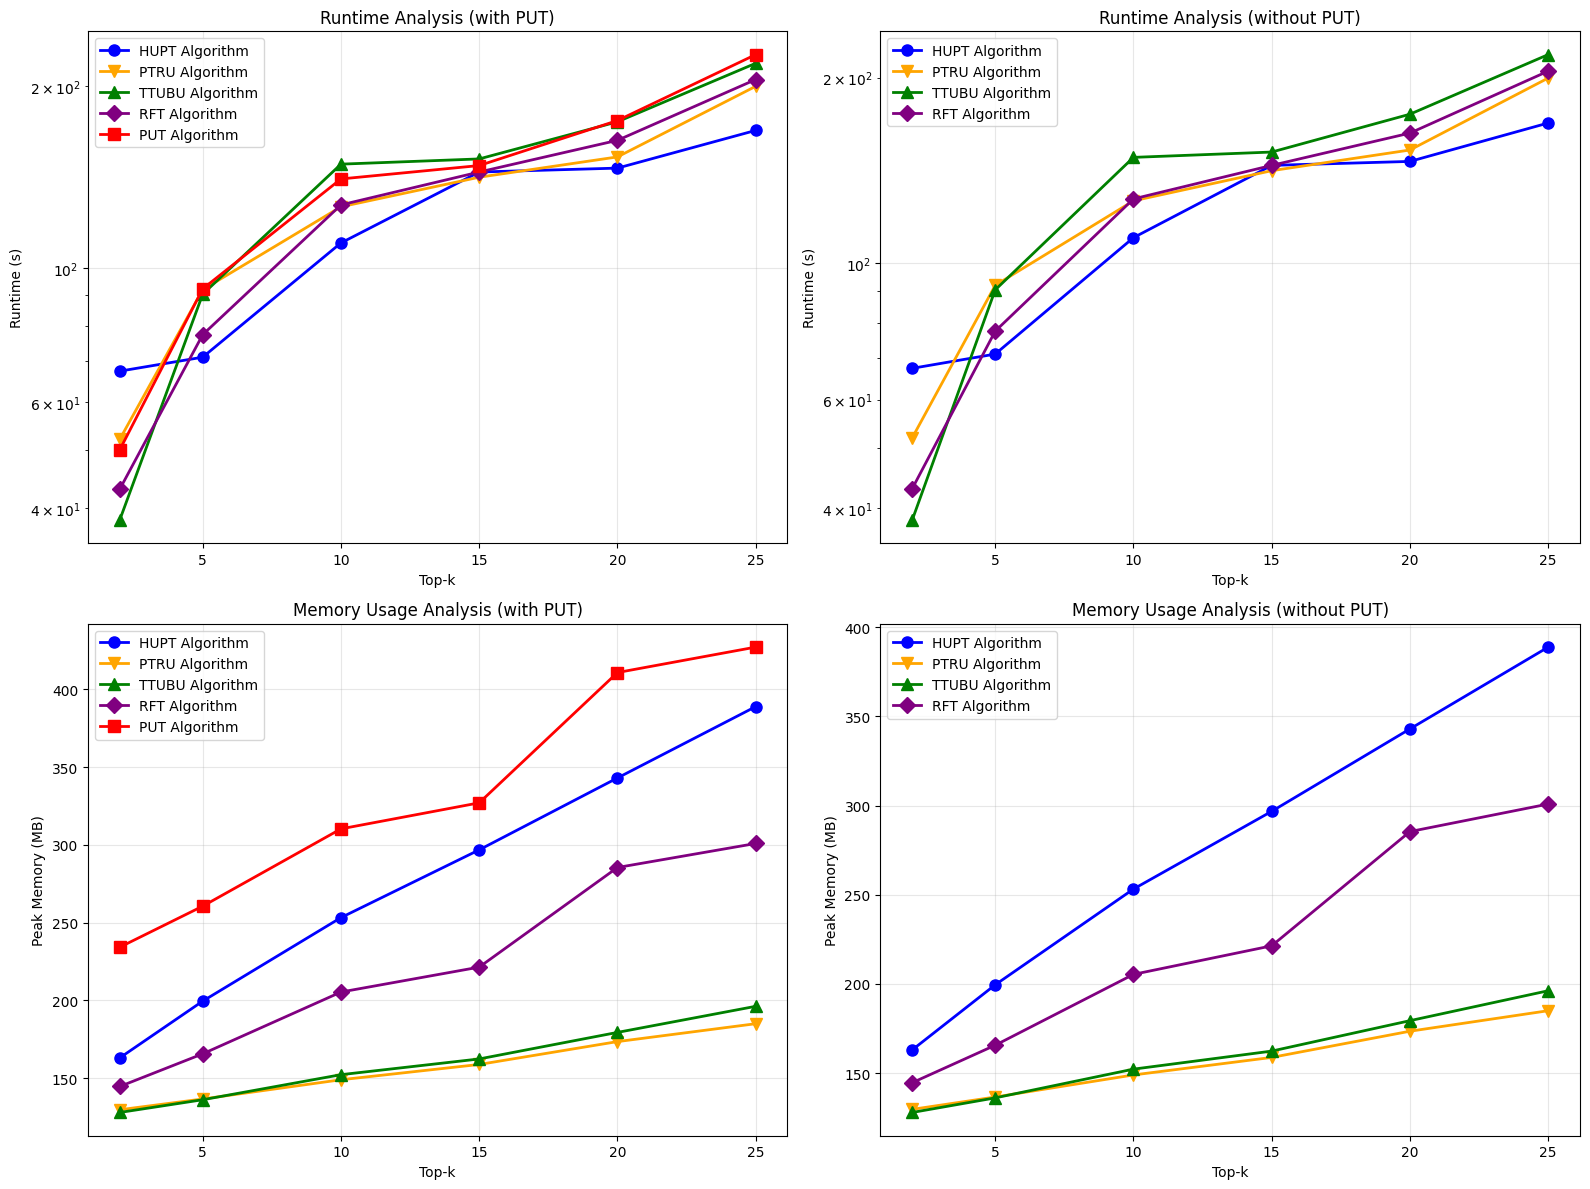

In [ ]:
analyzer = PerformanceAnalyzer()
k_values = [2, 5, 10, 15, 20, 25]

exec_times, mem_usage = analyzer.run_analysis(
    data_path="/content/Datasets/retail.json",
    k_values=k_values,
    min_utility=50
)


### Accident Dataset

Loading dataset from /content/Datasets/accident.json
Running performance analysis...
Analyzing performance with k=2
Analyzing performance with k=5
Analyzing performance with k=10
Analyzing performance with k=15
Plotting results...


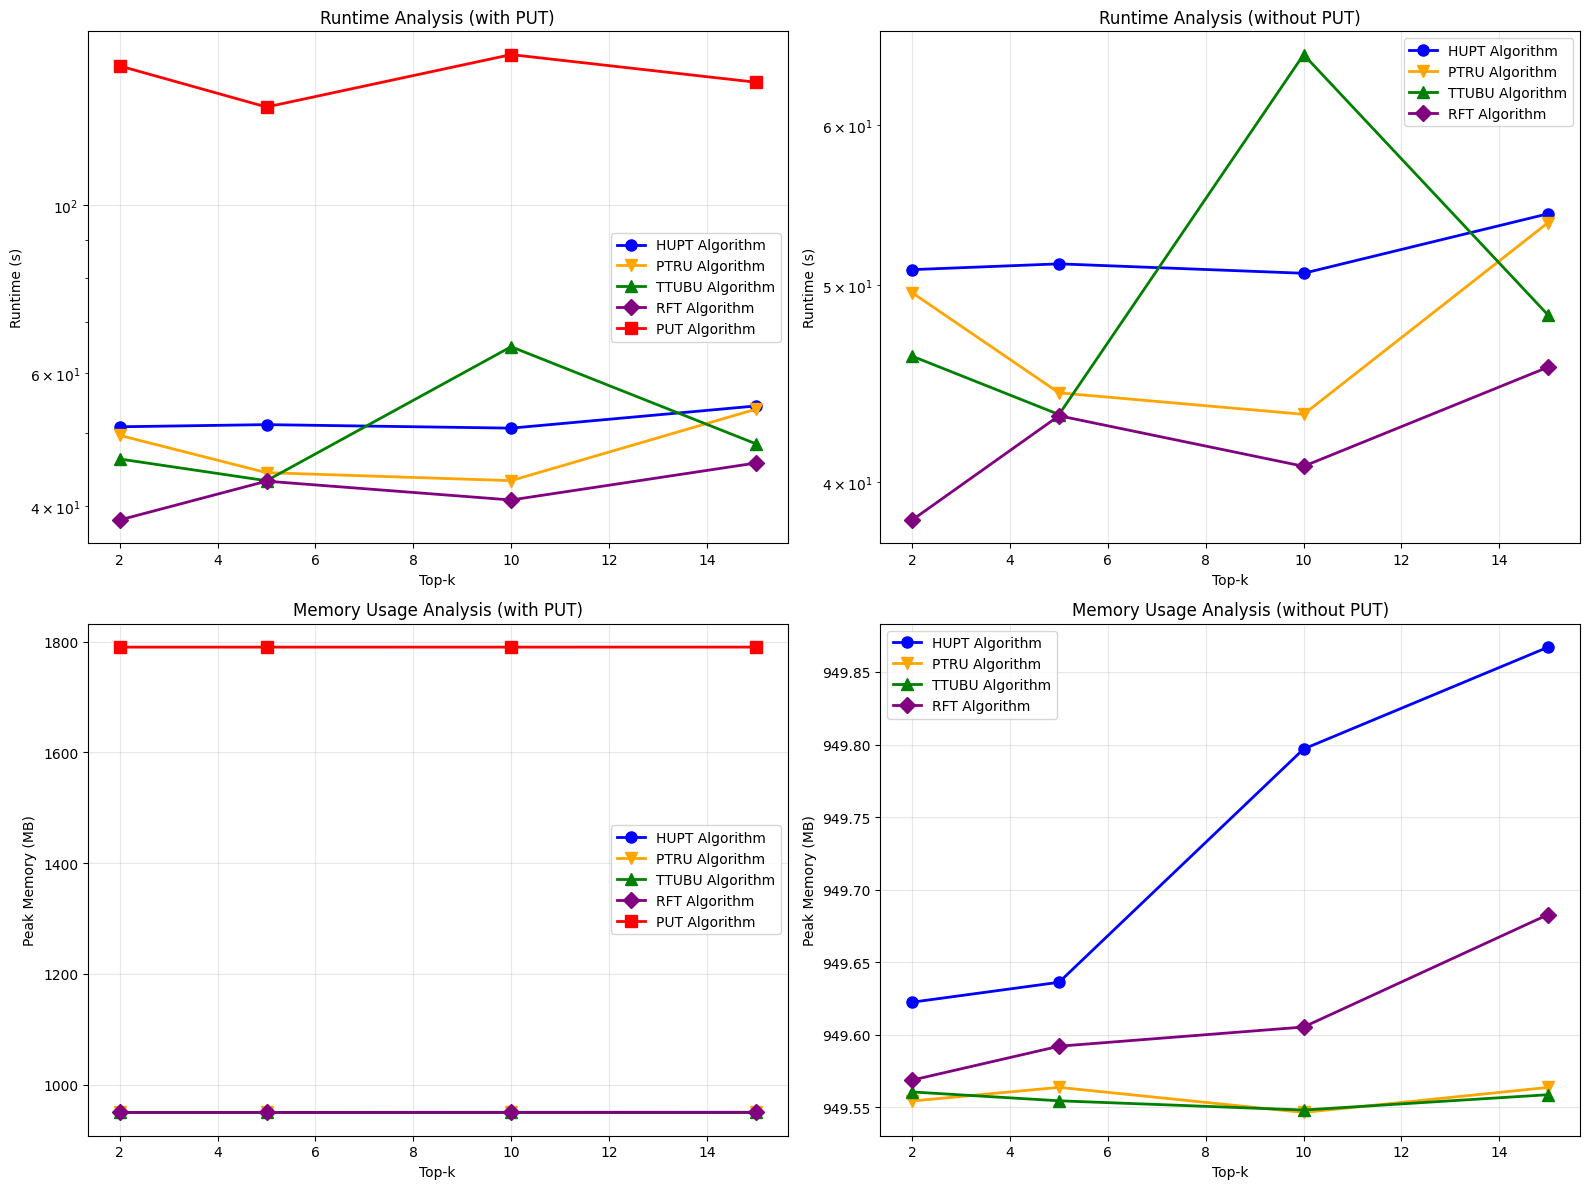

In [ ]:
analyzer = PerformanceAnalyzer()
k_values = [2, 5, 10, 15]

exec_times, mem_usage = analyzer.run_analysis(
    data_path="/content/Datasets/accident.json",
    k_values=k_values,
    min_utility=50
)


### Kosarak Dataset

Loading dataset from /content/Datasets/kosarak.json
Running performance analysis...
Analyzing performance with k=2
Analyzing performance with k=5
Analyzing performance with k=10
Plotting results...


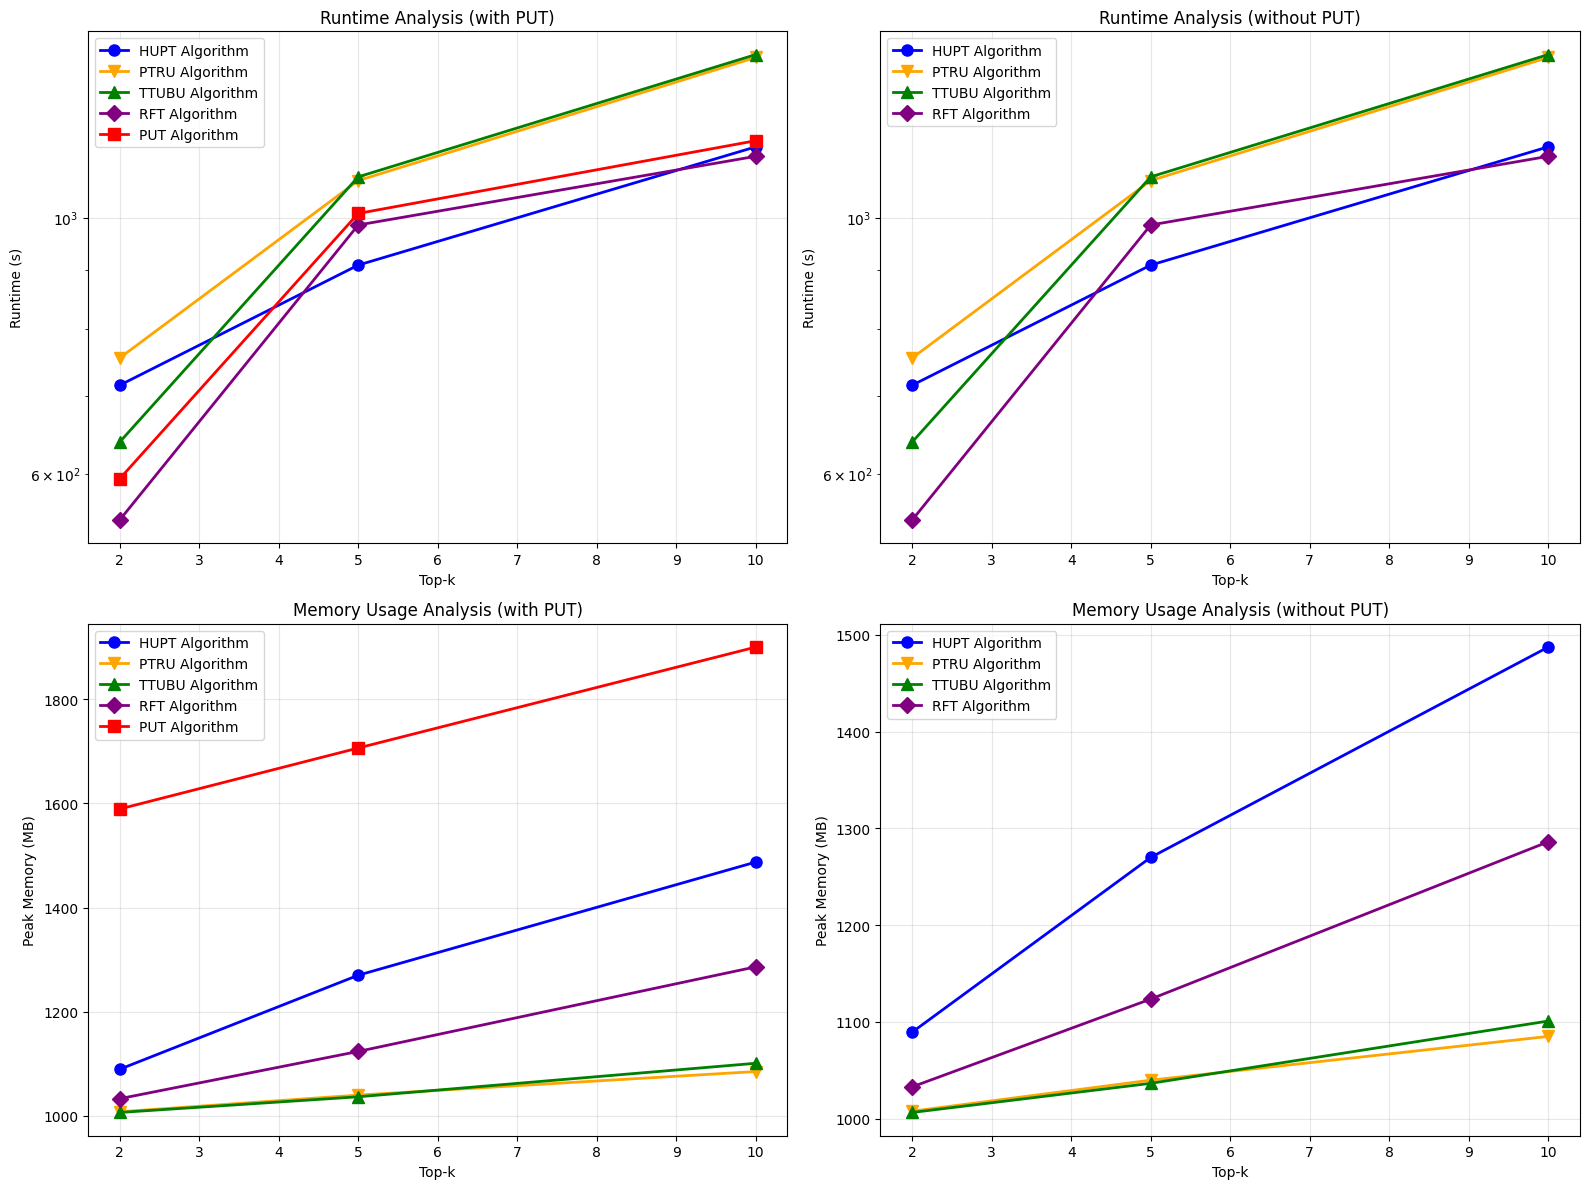

In [ ]:
analyzer = PerformanceAnalyzer()
k_values = [2, 5, 10]

exec_times, mem_usage = analyzer.run_analysis(
    data_path="/content/Datasets/kosarak.json",
    k_values=k_values,
    min_utility=50
)


### Mushroom Dataset

Loading dataset from /content/Datasets/mushroom.json
Running performance analysis...
Analyzing performance with k=2
Analyzing performance with k=5
Analyzing performance with k=10
Analyzing performance with k=15
Analyzing performance with k=20
Analyzing performance with k=25
Plotting results...


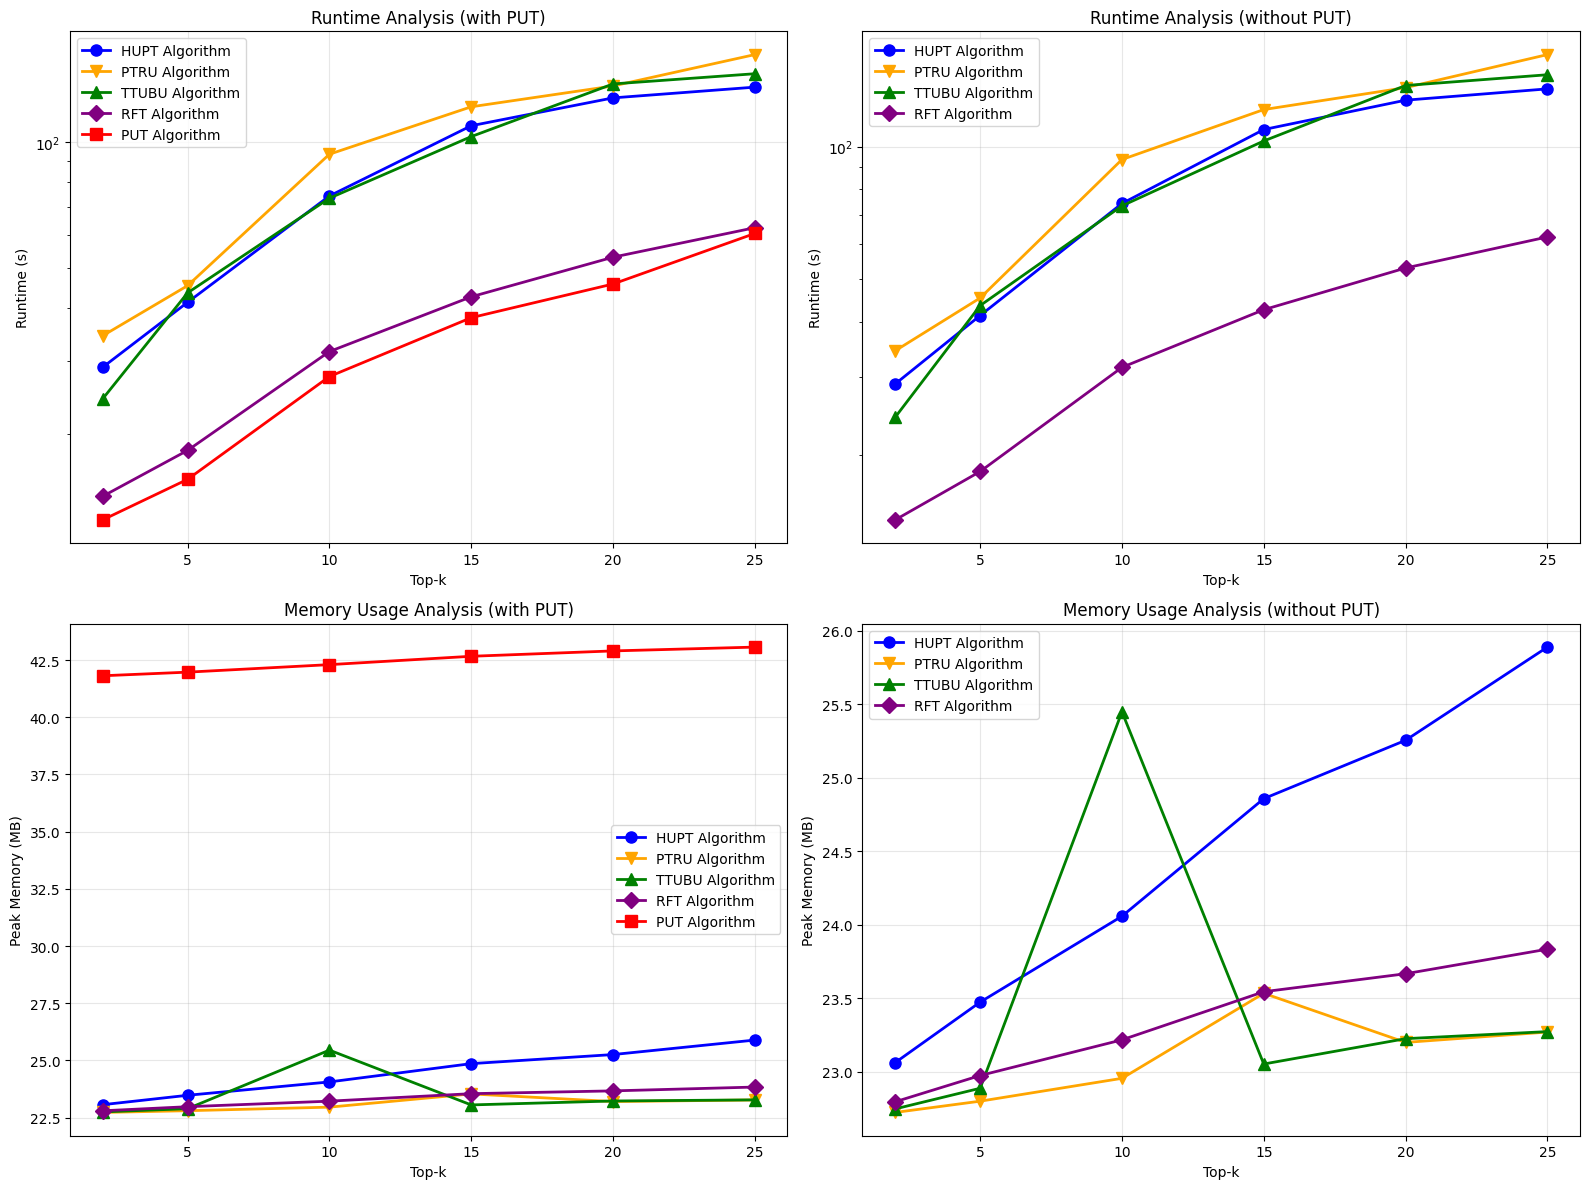

In [ ]:
analyzer = PerformanceAnalyzer()
k_values = [2, 5, 10, 15, 20, 25]

exec_times, mem_usage = analyzer.run_analysis(
    data_path="/content/Datasets/mushroom.json",
    k_values=k_values,
    min_utility=50
)


### Pumsb Dataset

In [ ]:
analyzer = PerformanceAnalyzer()
k_values = [2, 5, 10]

exec_times, mem_usage = analyzer.run_analysis(
    data_path="/content/Datasets/pumsb.json",
    k_values=k_values,
    min_utility=50
)


Loading dataset from /content/Datasets/pumsb.json
Running performance analysis...
Analyzing performance with k=2
Analyzing performance with k=5
Analyzing performance with k=10
